# Index and Table of Contents

** District Breakdowns of SLO
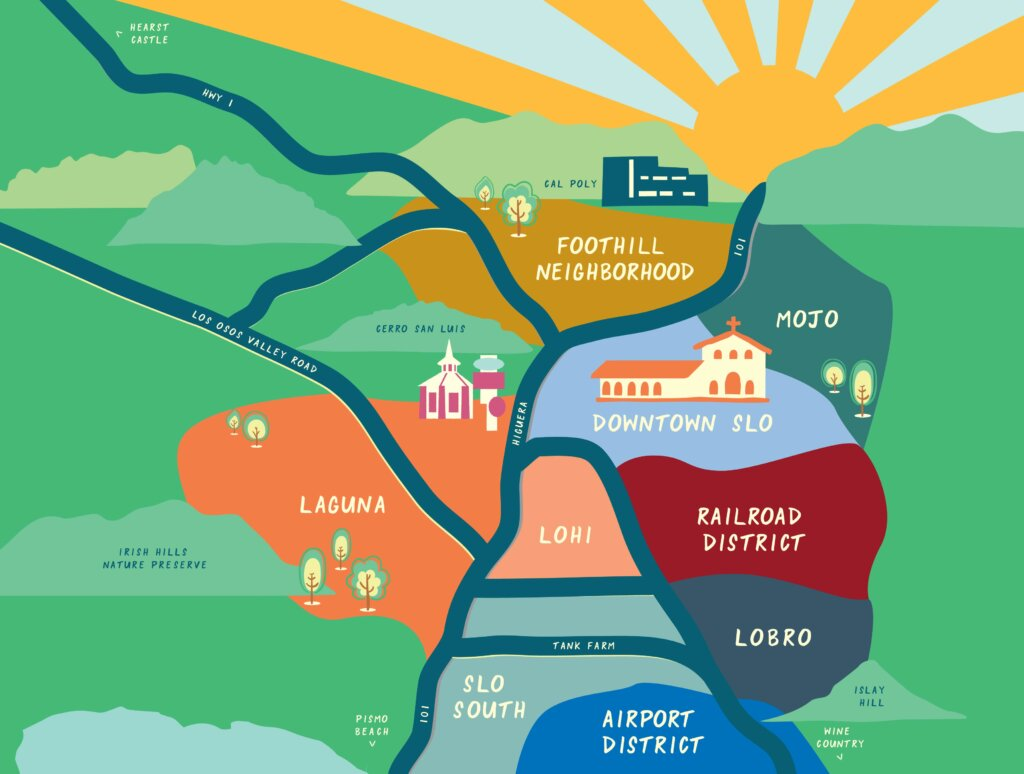

Provided by: https://visitslo.com/neighborhoods/

** Data Sets:

slo_re: standard imported data set from excel. Contains raw housing data and additions

slo_re_regression: Cleaned variant of slo_re designed to be ready for regression models.

slo_re_corr: dataset used for correlation matrix

slo_re_time: dataset used for time series analysis. Includes variables as datetime objects

slo_re_anova_price: includes variables cleaned and formatted for anova testing of various predictors intended to be used for creating predictive home pricing models

slo_re_regression: includes variables cleaned for use in predictive home pricing regression models

slo_re_map: includes cleaned location (latitude / longitude) variables to allow for geographical analysis and interactive projects

slo_re_anova: contains cleaned variables relevant to predictive days on market models

slo_re_anova2: larger data set than original, with intent of utilizing fewer predictor variables. Fewer observations are dropped as a result of fewer predictor variables

slo_re_anova_filtered: filtered variant of original, with some outliers pertaining to lot size being omitted



** Variables:

'Price Difference': Sell Price / List Price.

# Import Data; Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.anova as anova_lm
import folium
import matplotlib.colors as mcolors

from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import make_column_transformer
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap

Import Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

slo_re = pd.read_excel('input_file_path')
slo_re.tail()

** Drop sqft from vars

In [3]:
'''
def convert_lot_size(lot_size):
    if lot_size == "- -":
        return float('nan')

    # Remove commas
    lot_size = lot_size.replace(',', '')

    if 'sqft' in lot_size:
        # Remove 'sqft' and convert to int
        return int(float(lot_size.replace(' sqft', '')))
    elif 'acres' in lot_size:
        # Remove 'acres', convert to float, then to square feet, and finally to int
        acres = float(lot_size.replace(' acres', ''))
        sqft = acres * 43560
        return int(float(sqft))
    else:
        raise ValueError("Unexpected lot size format")


slo_re['Lot Size'] = slo_re['Lot Size'].apply(convert_lot_size)
slo_re['Square Footage'] = slo_re['Square Footage'].apply(convert_lot_size)
slo_re.head()
'''

'\ndef convert_lot_size(lot_size):\n    if lot_size == "- -":\n        return float(\'nan\')\n\n    # Remove commas\n    lot_size = lot_size.replace(\',\', \'\')\n\n    if \'sqft\' in lot_size:\n        # Remove \'sqft\' and convert to int\n        return int(float(lot_size.replace(\' sqft\', \'\')))\n    elif \'acres\' in lot_size:\n        # Remove \'acres\', convert to float, then to square feet, and finally to int\n        acres = float(lot_size.replace(\' acres\', \'\'))\n        sqft = acres * 43560\n        return int(float(sqft))\n    else:\n        raise ValueError("Unexpected lot size format")\n\n\nslo_re[\'Lot Size\'] = slo_re[\'Lot Size\'].apply(convert_lot_size)\nslo_re[\'Square Footage\'] = slo_re[\'Square Footage\'].apply(convert_lot_size)\nslo_re.head()\n'

In [4]:
'''
geolocator = Nominatim(user_agent="input_email_address")

geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

def get_coordinates(address, city):
    location = geocode(f"{address}, {city}")
    if location:
        return location.latitude, location.longitude
    else:
        return None, None

# Apply the function to get coordinates
slo_re[['Latitude', 'Longitude']] = slo_re.apply(lambda row: pd.Series(get_coordinates(row['Address'], row['City'])), axis=1)
slo_re.head()
'''

'\ngeolocator = Nominatim(user_agent="input_email_address")\n\ngeocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)\n\ndef get_coordinates(address, city):\n    location = geocode(f"{address}, {city}")\n    if location:\n        return location.latitude, location.longitude\n    else:\n        return None, None\n\n# Apply the function to get coordinates\nslo_re[[\'Latitude\', \'Longitude\']] = slo_re.apply(lambda row: pd.Series(get_coordinates(row[\'Address\'], row[\'City\'])), axis=1)\nslo_re.head()\n'

# Exploratory Analysis *General Summaries


In [5]:
slo_re.head()

,MLS #,List Price,Sell Price,Address,Structure Type,Property Type,Beds,Full Baths,Half Baths,Square Footage,...,Year Built,Common Interest,Days On Market,District,Price Difference,Cleaned Address,Latitude,Longitude,Price per/Sqft,Baths
0,MLS #SC24127762,663500,663500,"570 Peach Street #23 San Luis Obispo, CA 93401...",House,Residential,2,2.0,0,918,...,1975,Condominium,4.0,downtown,1.000000,570 Peach Street San Luis Obispo,35.281432,-120.667350,722.766885,2.0
1,MLS #SC24091640,2195000,2000000,"570 Pacific San Luis Obispo, CA 93401",House,Residential,3,3.0,1,2227,...,2024,NaN,57.0,downtown,0.911162,570 Pacific San Luis Obispo,35.280136,-120.658902,898.069151,3.5
2,MLS #SC24073717,1225000,1195000,"771 Toro Street San Luis Obispo, CA 93401-2830",House,Residential,2,2.0,0,1200,...,1925,NaN,68.0,downtown,0.975510,771 Toro Street San Luis Obispo,35.285476,-120.660686,995.833333,2.0
3,MLS #NS24109649,729000,729000,"1739 Johnson Avenue San Luis Obispo, CA 93401-...",House,Residential,2,1.0,0,900,...,1925,NaN,8.0,downtown,1.000000,1739 Johnson Avenue San Luis Obispo,35.279243,-120.650931,810.000000,1.0
4,MLS #SC23208408,1194000,1300000,"1143 Peach Street San Luis Obispo, CA 93401-2818",House,Residential,2,2.0,0,1100,...,1906,NaN,143.0,downtown,1.088777,1143 Peach Street San Luis Obispo,35.285429,-120.661198,1181.818182,2.0


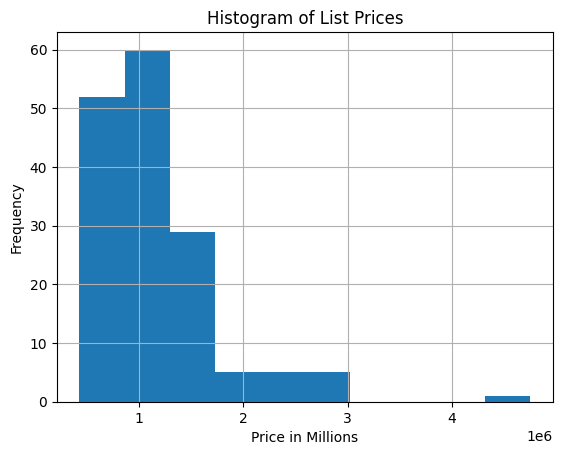

In [6]:
# Distribution of List Price across all Districts
slo_re['List Price'].hist(bins=10)
plt.title(f'Histogram of List Prices')
plt.xlabel('Price in Millions')
plt.ylabel('Frequency')
plt.show()

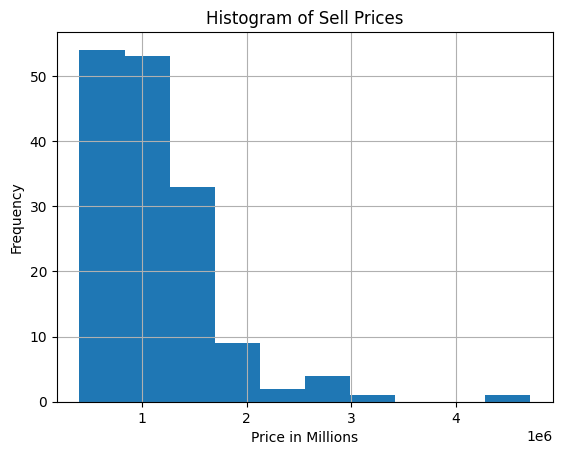

In [7]:
# Distribution of Sell Price across all Districts
slo_re['Sell Price'].hist(bins=10)
plt.title(f'Histogram of Sell Prices')
plt.xlabel('Price in Millions')
plt.ylabel('Frequency')
plt.show()

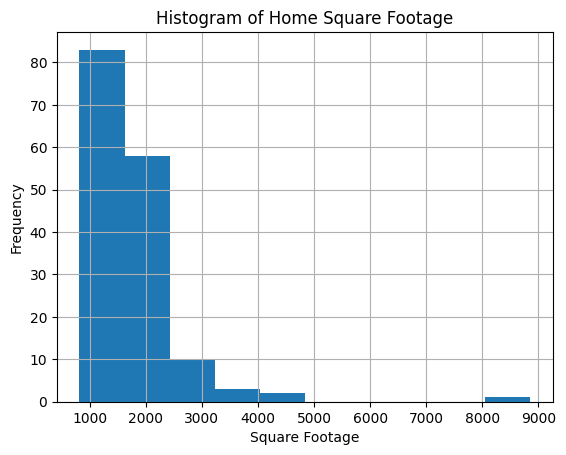

In [8]:
# Distribution of Home Square Footage across all Districts
slo_re['Square Footage'].hist(bins=10)
plt.title(f'Histogram of Home Square Footage')
plt.xlabel('Square Footage')
plt.ylabel('Frequency')
plt.show()

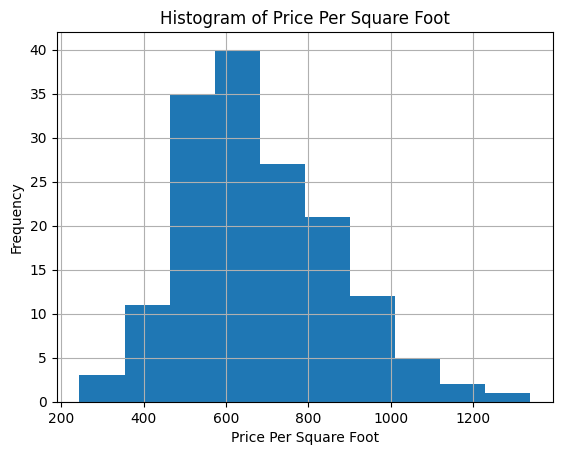

In [9]:
# Distribution of Home Square Footage across all Districts
slo_re['Price per/Sqft'].hist(bins=10)
plt.title(f'Histogram of Price Per Square Foot')
plt.xlabel('Price Per Square Foot')
plt.ylabel('Frequency')
plt.show()

In [10]:
# Price Info
Mean_Price = slo_re['Sell Price'].mean()
Median_Price = slo_re['Sell Price'].median()
Price_STD = slo_re['Sell Price'].std()
Price_Max = slo_re['Sell Price'].max()
Price_Min = slo_re['Sell Price'].min()

print(f"Mean Price: {Mean_Price}")
print(f"Median Price: {Median_Price}")
print(f"Price Standard Deviation: {Price_STD}")
print(f"Max Price: {Price_Max}")
print(f"Min Price: {Price_Min}")

# Size Info

sqft_mean = slo_re['Square Footage'].mean()
sqft_median = slo_re['Square Footage'].median()
sqft_std = slo_re['Square Footage'].std()
lotSize_mean = slo_re['Lot Size'].mean()
lotSize_median = slo_re['Lot Size'].median()
lotSize_std = slo_re['Lot Size'].std()
price_sqft_mean = slo_re['Price per/Sqft'].mean()
price_sqft_median = slo_re['Price per/Sqft'].median()
price_sqft_std = slo_re['Price per/Sqft'].std()

print(f"Mean Square Footage: {sqft_mean}")
print(f"Median Square Footage: {sqft_median}")
print(f"Square Footage Standard Deviation: {sqft_std}")
print(f"Mean Lot Size: {lotSize_mean}")
print(f"Median Lot Size: {lotSize_median}")
print(f"Lot Size Standard Deviation: {lotSize_std}")
print(f"Mean Price per/Sqft: {price_sqft_mean}")
print(f"Median Price per/Sqft: {price_sqft_median}")
print(f"Price per/Sqft Standard Deviation: {price_sqft_std}")

Mean Price: 1136763.694267516
Median Price: 1001000.0
Price Standard Deviation: 581567.6569390136
Max Price: 4713000
Min Price: 400000
Mean Square Footage: 1704.7579617834394
Median Square Footage: 1565.0
Square Footage Standard Deviation: 872.3239180287618
Mean Lot Size: 107279.69736842105
Median Lot Size: 5743.0
Lot Size Standard Deviation: 1225599.9821645352
Mean Price per/Sqft: 681.2317979700252
Median Price per/Sqft: 648.3126110124334
Price per/Sqft Standard Deviation: 187.14389566999117


In [11]:
# Average difference in List Price vs Sale Price across SLO
Mean_Price_Diff = (slo_re['Price Difference'].mean() - 1) * 100
print("Mean Percentage Difference in List Price vs Sale Price: ", Mean_Price_Diff)

Mean Percentage Difference in List Price vs Sale Price:  -1.3869688095026422


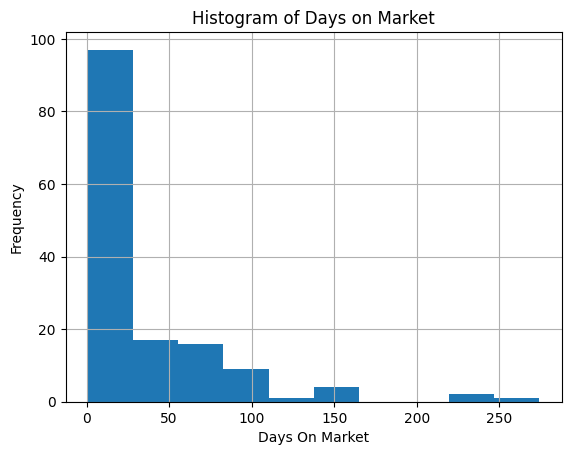

In [12]:
# Distribution of days on market
slo_re['Days On Market'].hist(bins=10)
plt.title(f'Histogram of Days on Market')
plt.xlabel('Days On Market')
plt.ylabel('Frequency')
plt.show()

In [13]:
slo_re['Days On Market'].median()

12.0

In [14]:
slo_re.columns

Index(['MLS #', 'List Price', 'Sell Price', 'Address', 'Structure Type',
       'Property Type', 'Beds', 'Full Baths', 'Half Baths', 'Square Footage',
       'Lot Size', 'HOA Fee', 'Parking Spots', 'Garage Spaces', 'Closed On',
       'Stories', 'Style', 'Attached Garage', 'Road Frontage',
       'New Construction', 'Year Built', 'Common Interest', 'Days On Market',
       'District', 'Price Difference', 'Cleaned Address', 'Latitude',
       'Longitude', 'Price per/Sqft', 'Baths'],
      dtype='object')

In [15]:
slo_re_corr = slo_re[['List Price', 'Sell Price', 'Beds', 'Full Baths', 'Half Baths', 'Square Footage',
                      'Lot Size', 'HOA Fee', 'Parking Spots', 'Garage Spaces', 'Stories', 'Year Built',
                      'Days On Market', 'Price per/Sqft', 'Baths', 'Longitude', 'Latitude']]

<Axes: >

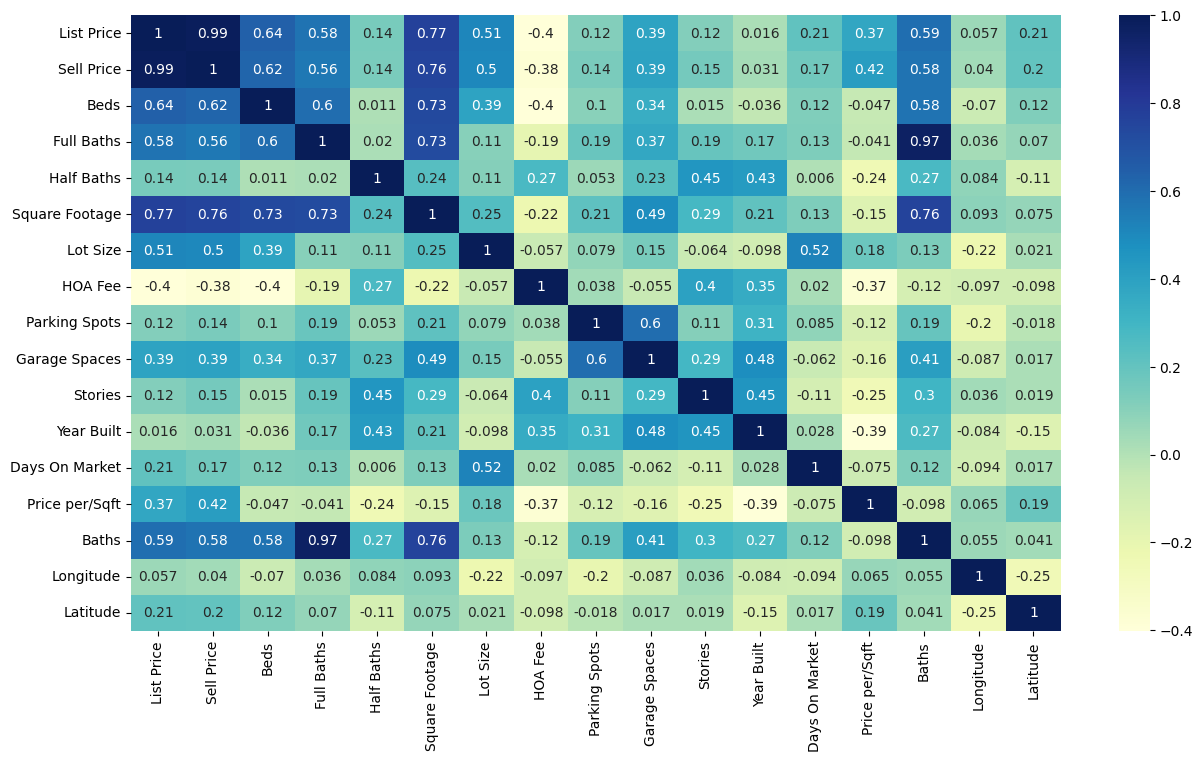

In [16]:
# Correlation matrix of quantitative variables
plt.figure(figsize=(15, 8))
sns.heatmap(slo_re_corr.corr(), annot=True, cmap='YlGnBu')

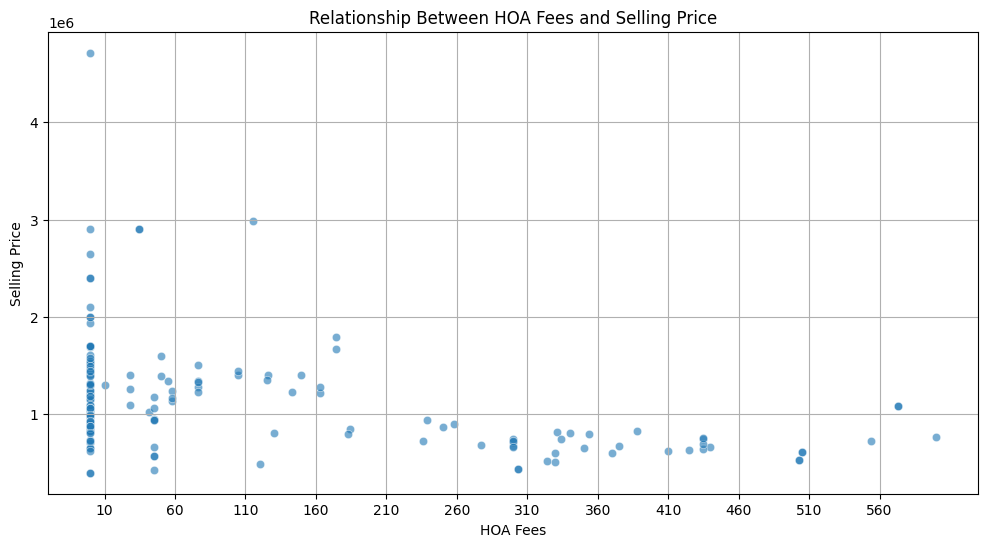

In [17]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=slo_re, x='HOA Fee', y='Sell Price', alpha=0.6)
x_ticks = np.arange(10, 600, 50)
plt.xticks(x_ticks)

plt.title('Relationship Between HOA Fees and Selling Price')
plt.xlabel('HOA Fees')
plt.ylabel('Selling Price')

plt.grid(True)
plt.show()

# Exploratory Analysis *District-Specific Summaries

In [18]:
slo_re.head()

,MLS #,List Price,Sell Price,Address,Structure Type,Property Type,Beds,Full Baths,Half Baths,Square Footage,...,Year Built,Common Interest,Days On Market,District,Price Difference,Cleaned Address,Latitude,Longitude,Price per/Sqft,Baths
0,MLS #SC24127762,663500,663500,"570 Peach Street #23 San Luis Obispo, CA 93401...",House,Residential,2,2.0,0,918,...,1975,Condominium,4.0,downtown,1.000000,570 Peach Street San Luis Obispo,35.281432,-120.667350,722.766885,2.0
1,MLS #SC24091640,2195000,2000000,"570 Pacific San Luis Obispo, CA 93401",House,Residential,3,3.0,1,2227,...,2024,NaN,57.0,downtown,0.911162,570 Pacific San Luis Obispo,35.280136,-120.658902,898.069151,3.5
2,MLS #SC24073717,1225000,1195000,"771 Toro Street San Luis Obispo, CA 93401-2830",House,Residential,2,2.0,0,1200,...,1925,NaN,68.0,downtown,0.975510,771 Toro Street San Luis Obispo,35.285476,-120.660686,995.833333,2.0
3,MLS #NS24109649,729000,729000,"1739 Johnson Avenue San Luis Obispo, CA 93401-...",House,Residential,2,1.0,0,900,...,1925,NaN,8.0,downtown,1.000000,1739 Johnson Avenue San Luis Obispo,35.279243,-120.650931,810.000000,1.0
4,MLS #SC23208408,1194000,1300000,"1143 Peach Street San Luis Obispo, CA 93401-2818",House,Residential,2,2.0,0,1100,...,1906,NaN,143.0,downtown,1.088777,1143 Peach Street San Luis Obispo,35.285429,-120.661198,1181.818182,2.0


Histograms of Variables by District

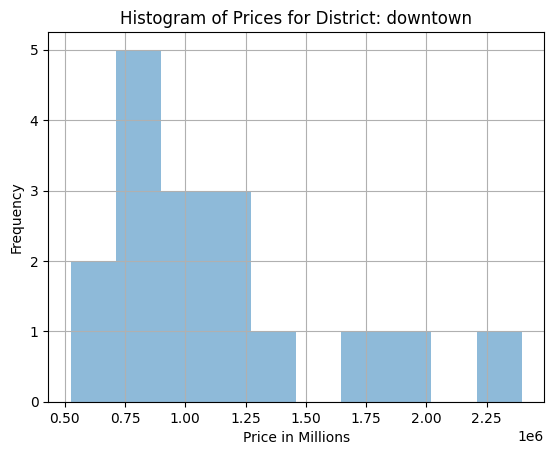

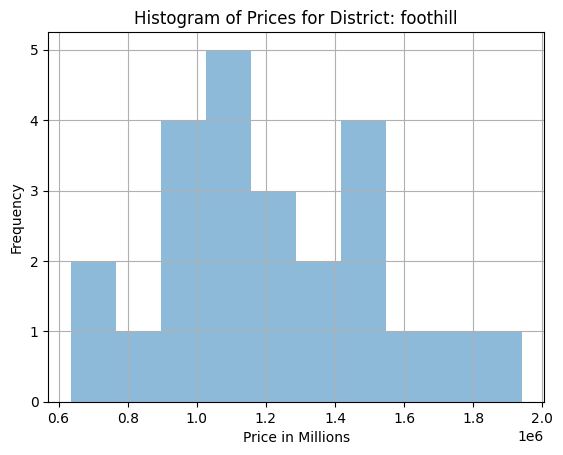

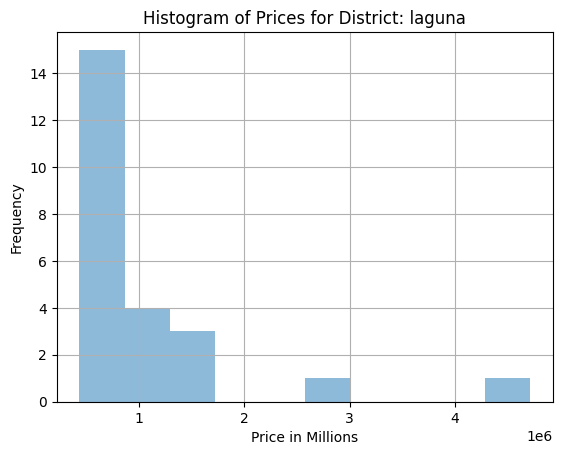

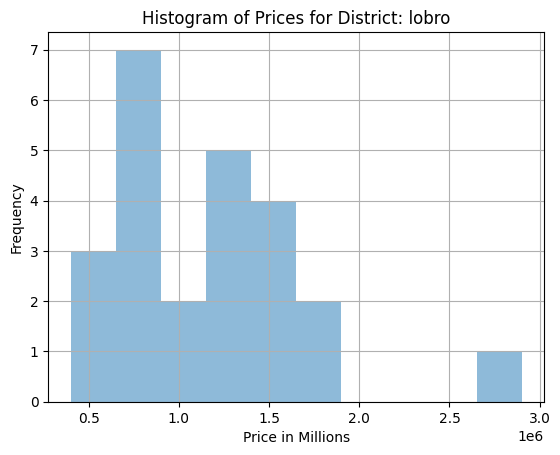

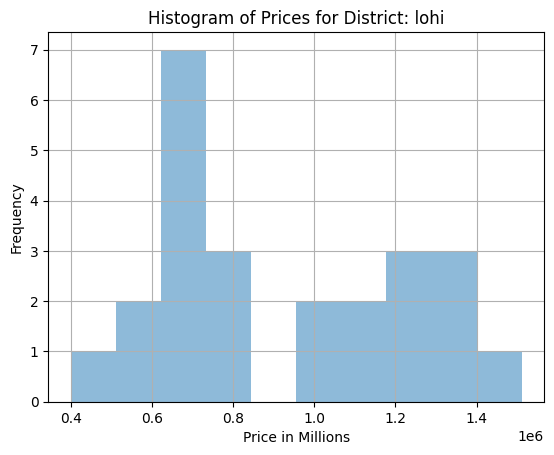

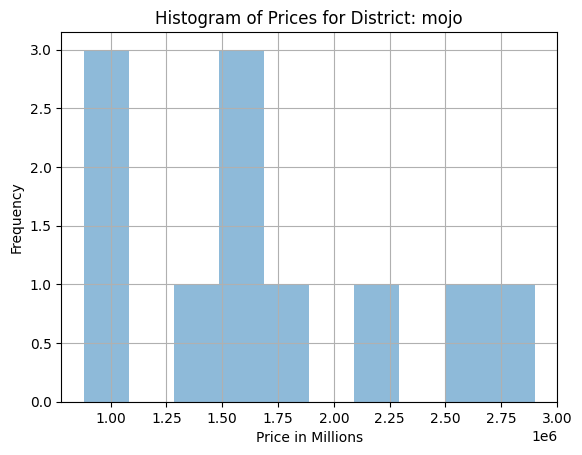

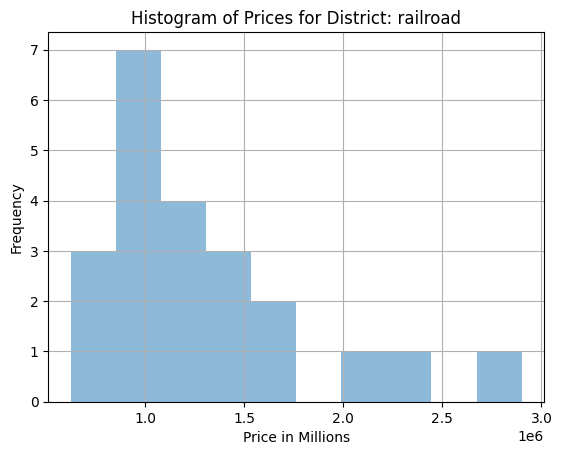

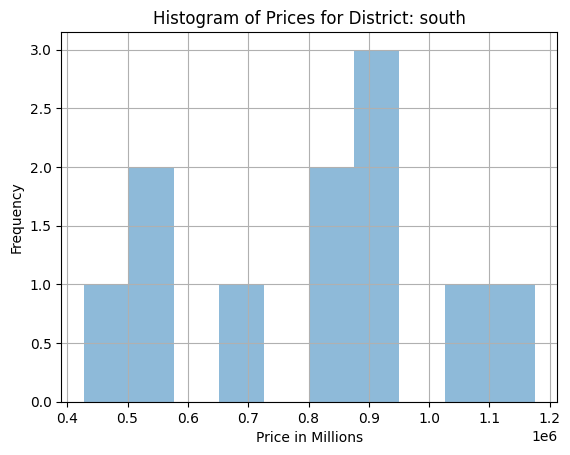

In [19]:
districts = slo_re['District'].unique()

for district in districts:
    slo_re[slo_re['District'] == district].hist(column='Sell Price', bins=10, alpha=0.5)
    plt.title(f'Histogram of Prices for District: {district}')
    plt.xlabel('Price in Millions')
    plt.ylabel('Frequency')
    plt.show()

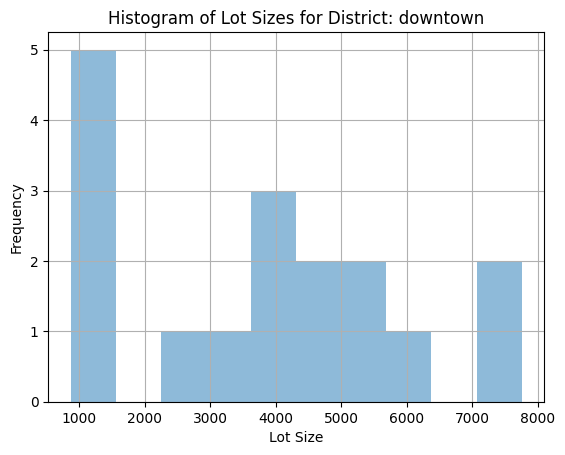

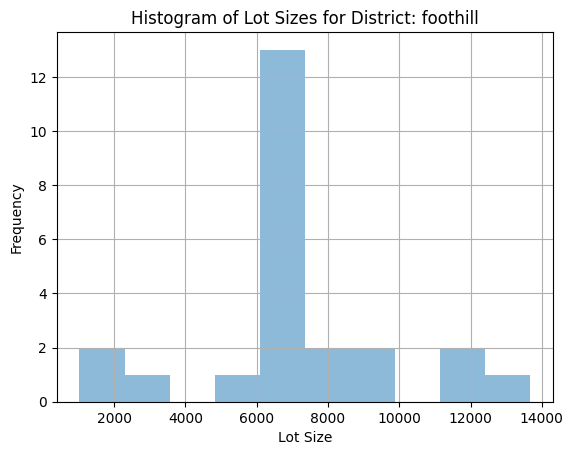

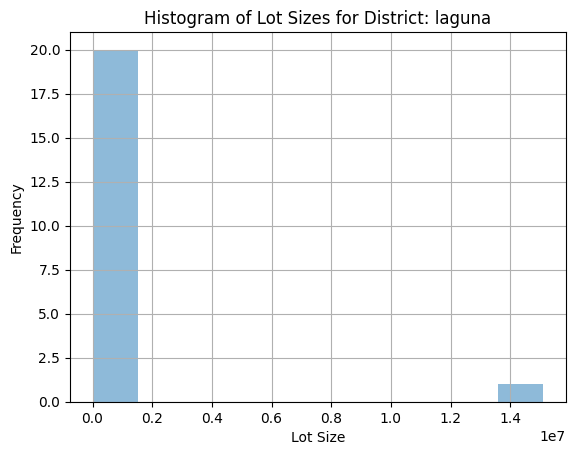

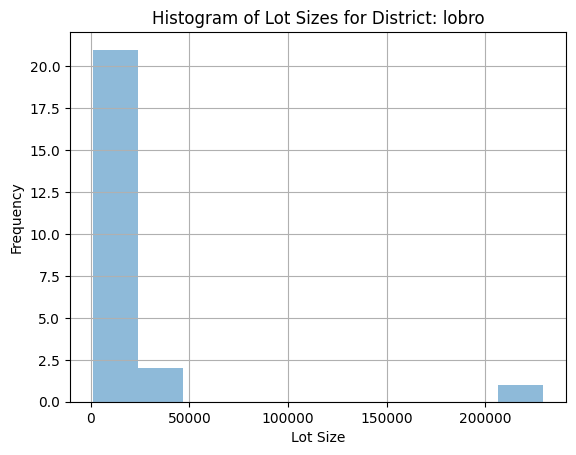

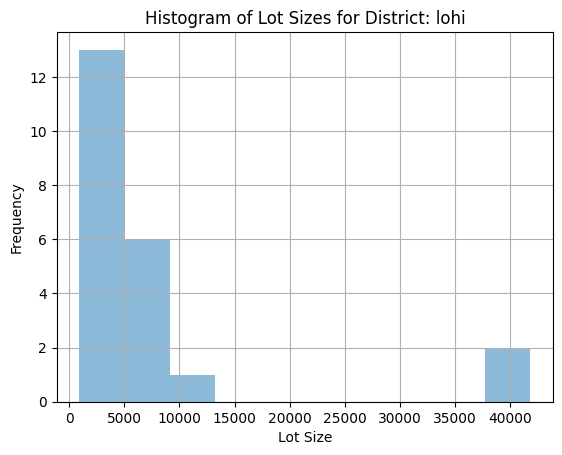

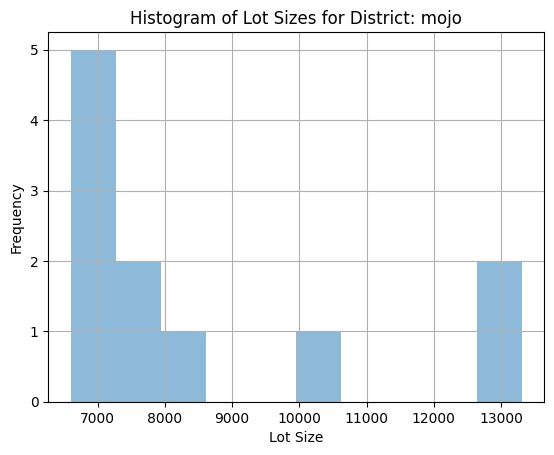

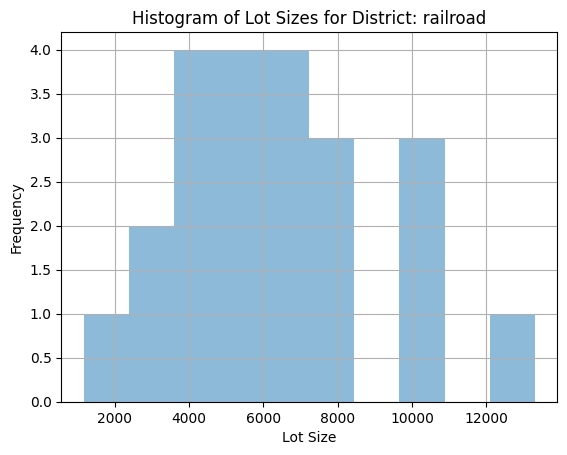

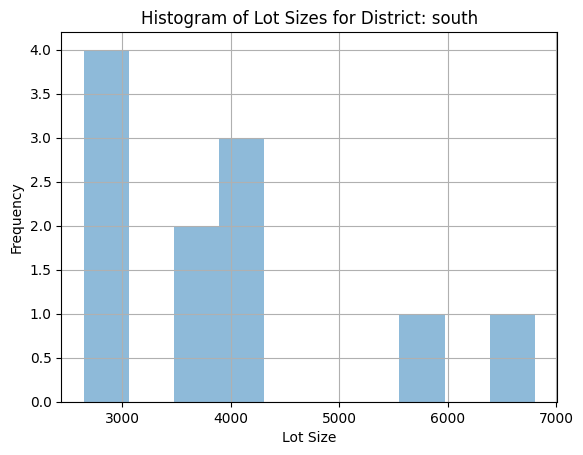

In [20]:
districts = slo_re['District'].unique()

for district in districts:
    slo_re[slo_re['District'] == district].hist(column='Lot Size', bins=10, alpha=0.5)
    plt.title(f'Histogram of Lot Sizes for District: {district}')
    plt.xlabel('Lot Size')
    plt.ylabel('Frequency')
    plt.show()

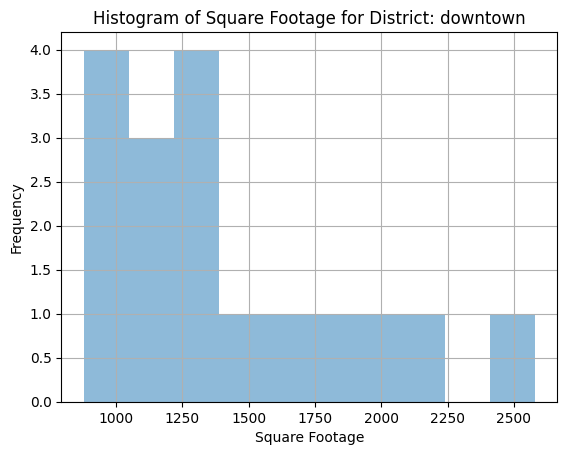

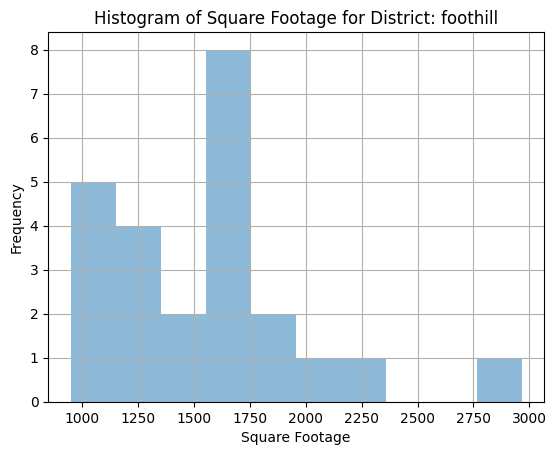

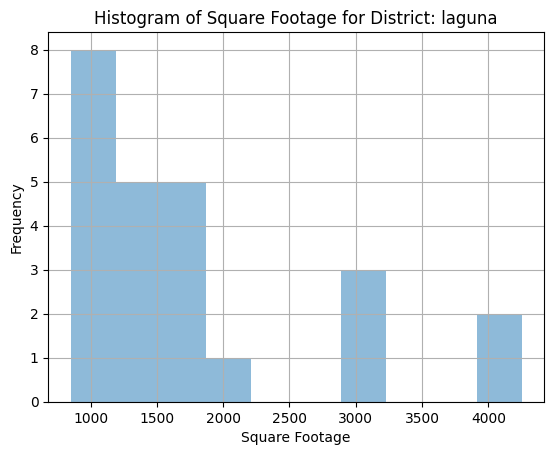

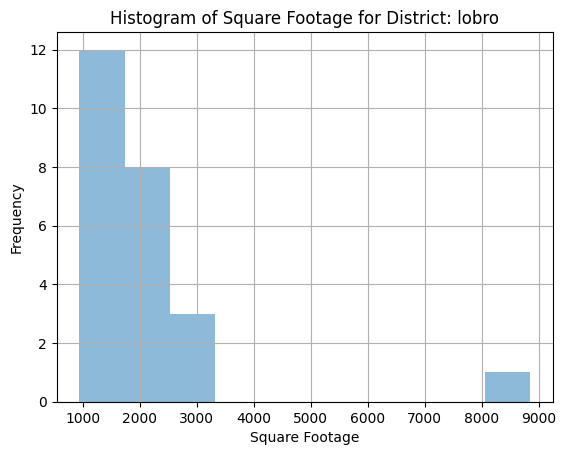

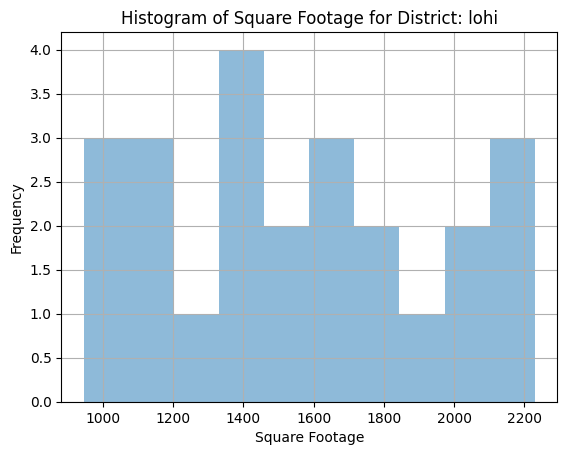

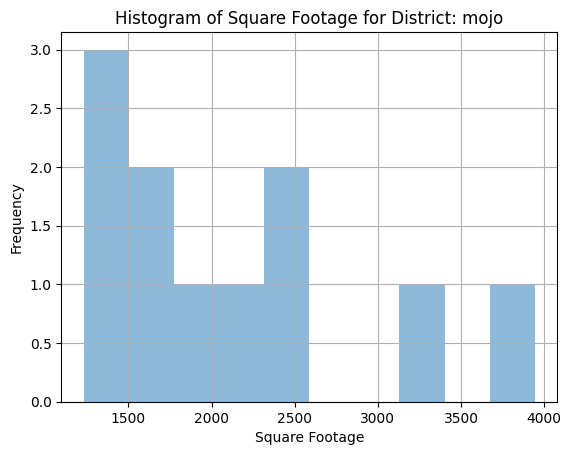

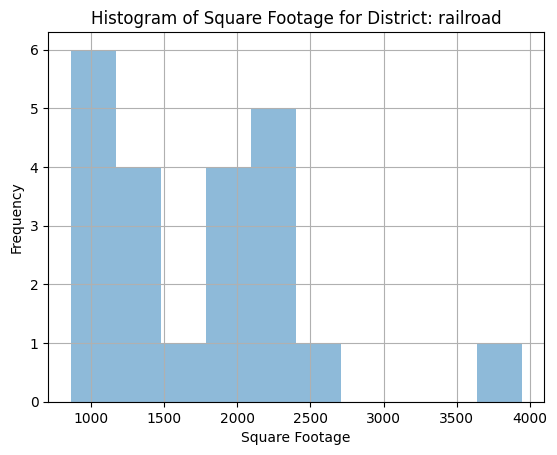

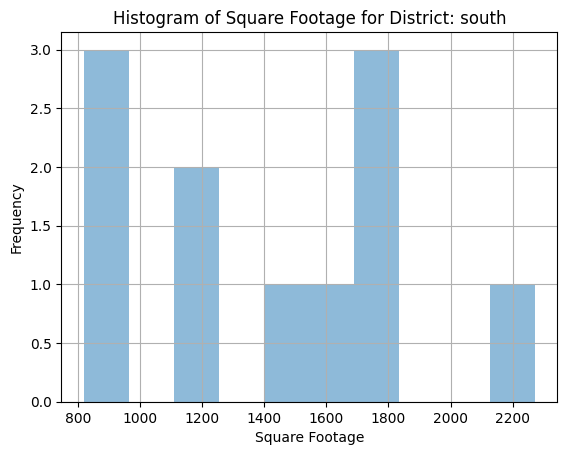

In [21]:
districts = slo_re['District'].unique()

for district in districts:
    slo_re[slo_re['District'] == district].hist(column='Square Footage', bins=10, alpha=0.5)
    plt.title(f'Histogram of Square Footage for District: {district}')
    plt.xlabel('Square Footage')
    plt.ylabel('Frequency')
    plt.show()

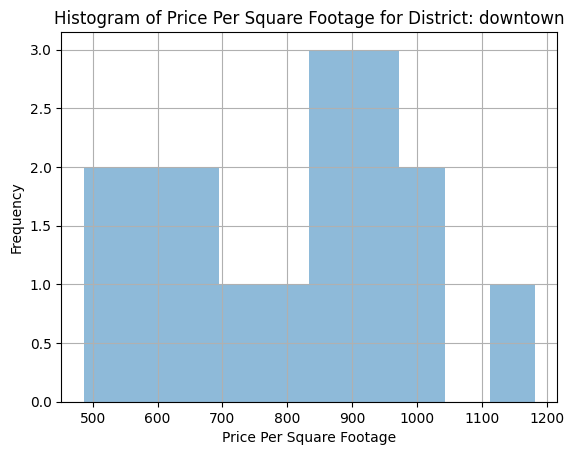

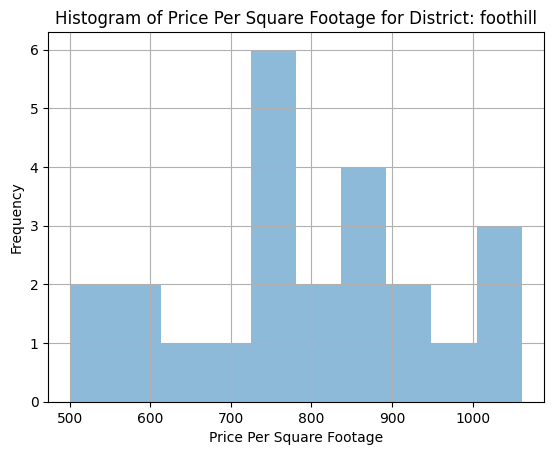

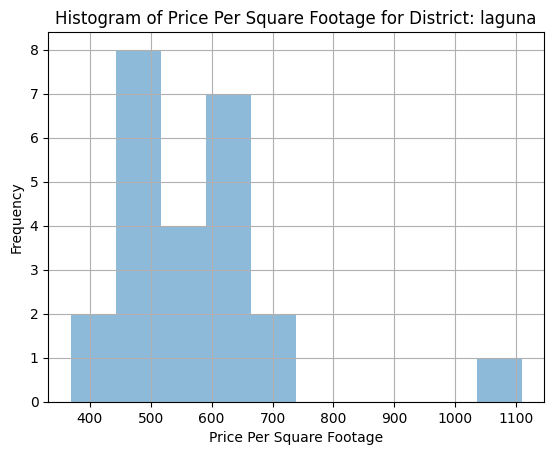

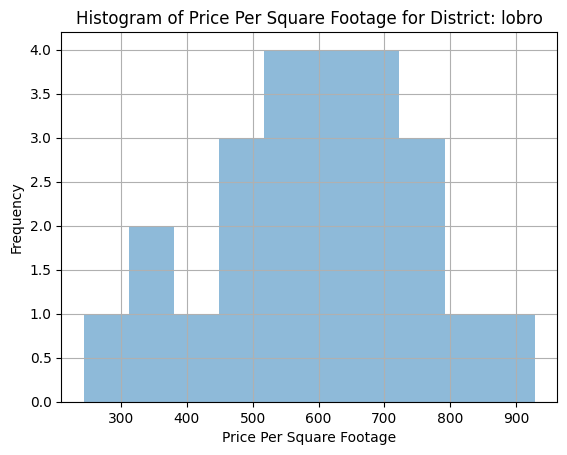

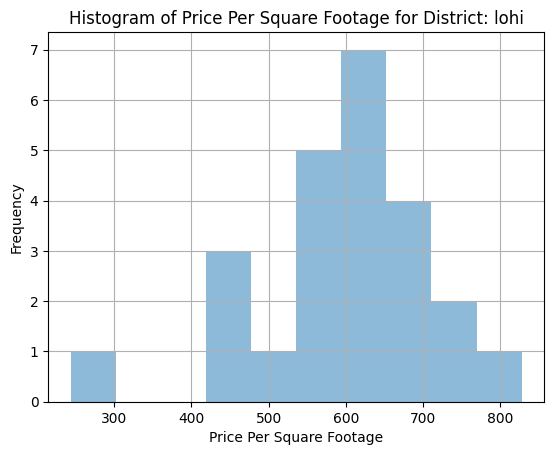

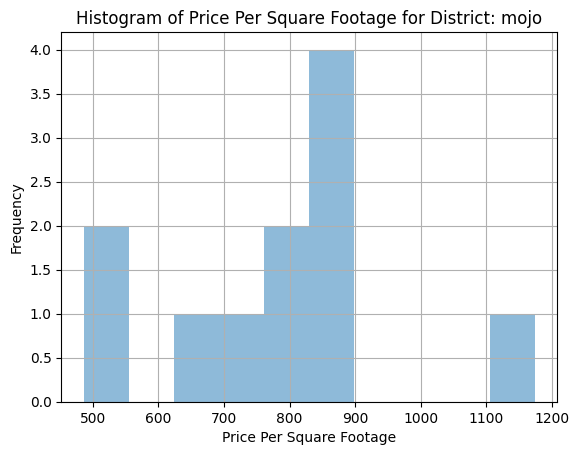

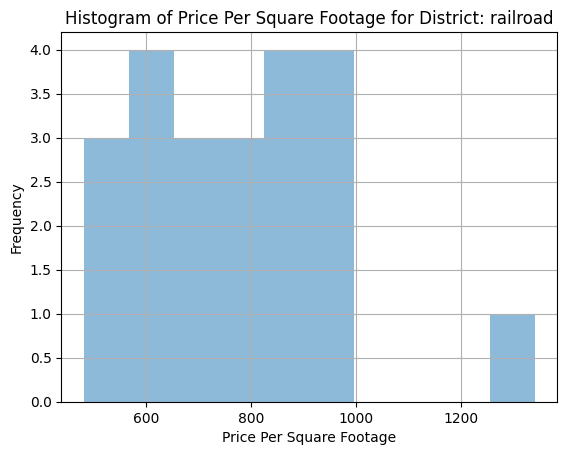

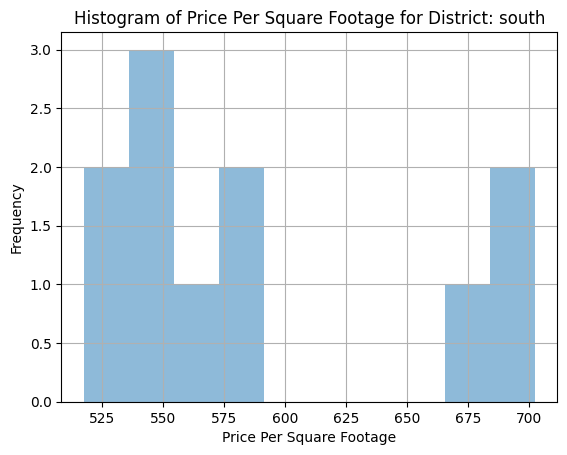

In [22]:
districts = slo_re['District'].unique()

for district in districts:
    slo_re[slo_re['District'] == district].hist(column='Price per/Sqft', bins=10, alpha=0.5)
    plt.title(f'Histogram of Price Per Square Footage for District: {district}')
    plt.xlabel('Price Per Square Footage')
    plt.ylabel('Frequency')
    plt.show()

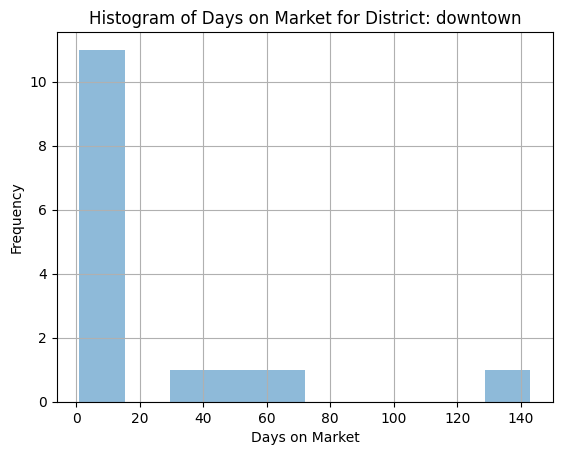

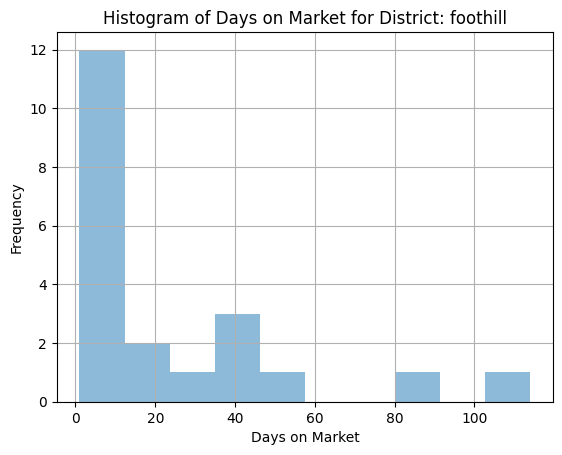

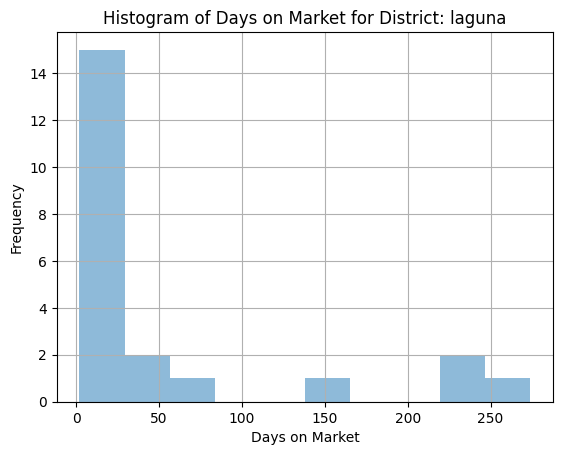

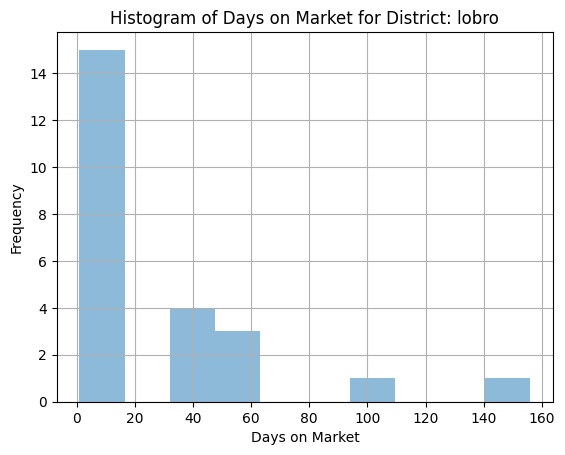

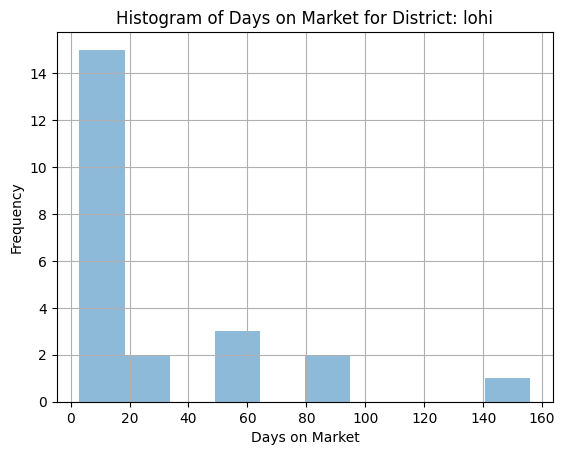

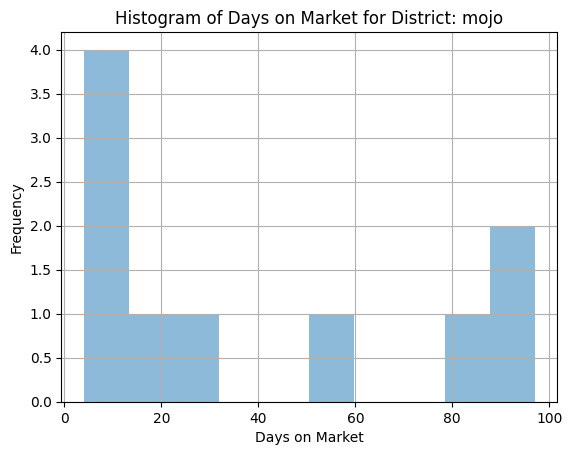

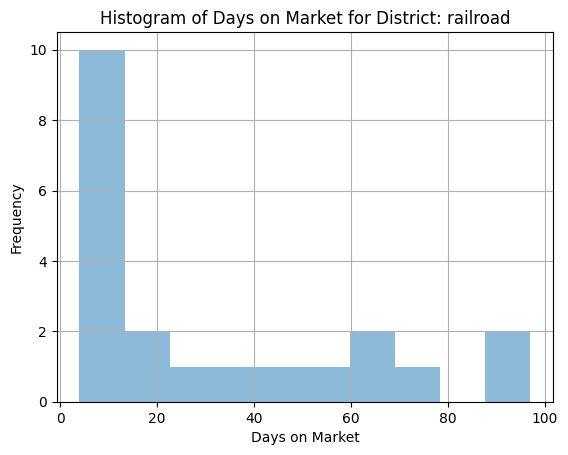

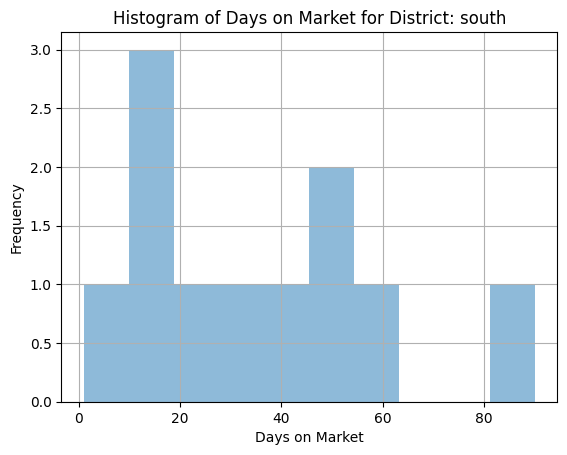

In [23]:
# Days on market distribution by district
districts = slo_re['District'].unique()

for district in districts:
    slo_re[slo_re['District'] == district].hist(column='Days On Market', bins=10, alpha=0.5)
    plt.title(f'Histogram of Days on Market for District: {district}')
    plt.xlabel('Days on Market')
    plt.ylabel('Frequency')
    plt.show()

In [24]:
# Days on market breakdown by district
districts = slo_re['District'].unique()

for district in districts:
    mean = slo_re[slo_re['District'] == district]['Days On Market'].mean()
    median = slo_re[slo_re['District'] == district]['Days On Market'].mean()
    std = slo_re[slo_re['District'] == district]['Days On Market'].mean()
    print(f'{district} - Mean days on market: {mean}, Median days on market: {median}, STD days on market {std}')

downtown - Mean days on market: 25.133333333333333, Median days on market: 25.133333333333333, STD days on market 25.133333333333333
foothill - Mean days on market: 23.571428571428573, Median days on market: 23.571428571428573, STD days on market 23.571428571428573
laguna - Mean days on market: 53.95454545454545, Median days on market: 53.95454545454545, STD days on market 53.95454545454545
lobro - Mean days on market: 27.958333333333332, Median days on market: 27.958333333333332, STD days on market 27.958333333333332
lohi - Mean days on market: 29.043478260869566, Median days on market: 29.043478260869566, STD days on market 29.043478260869566
mojo - Mean days on market: 38.7, Median days on market: 38.7, STD days on market 38.7
railroad - Mean days on market: 31.857142857142858, Median days on market: 31.857142857142858, STD days on market 31.857142857142858
south - Mean days on market: 34.63636363636363, Median days on market: 34.63636363636363, STD days on market 34.63636363636363


Break Down of Property Type by District

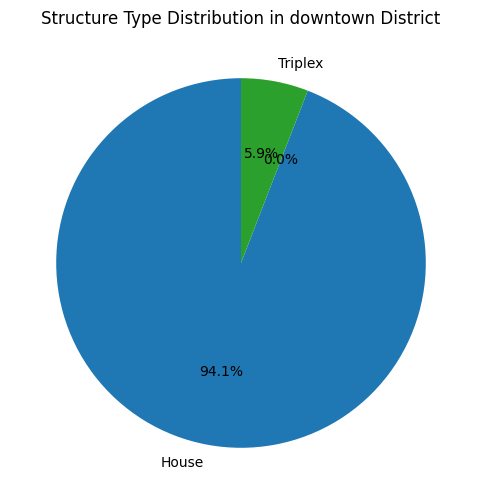

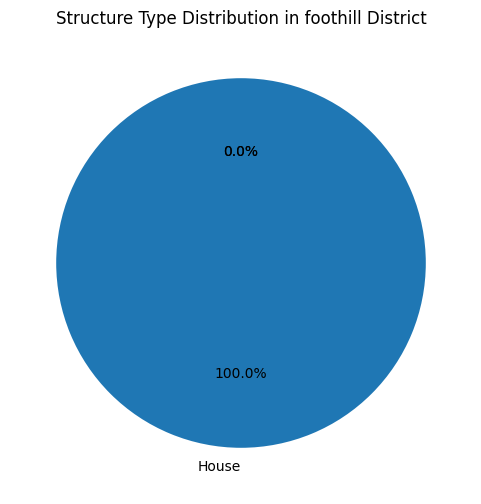

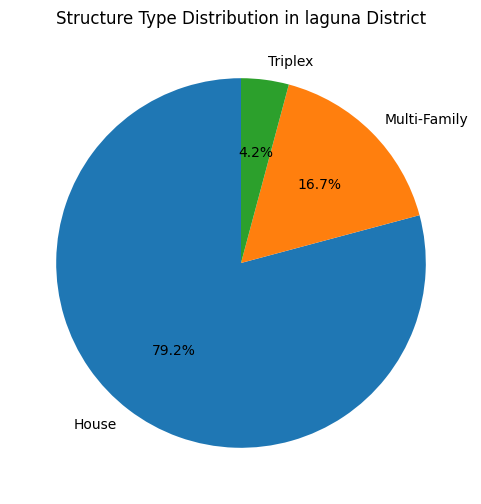

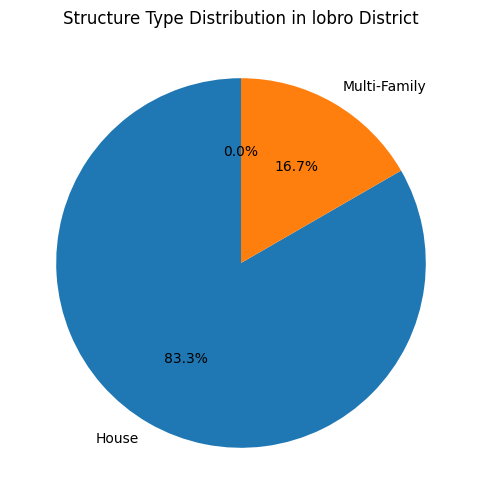

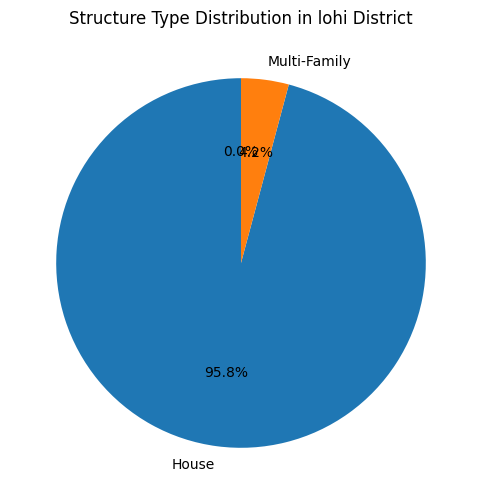

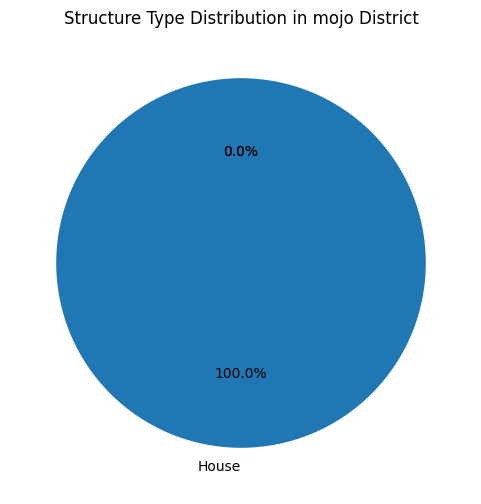

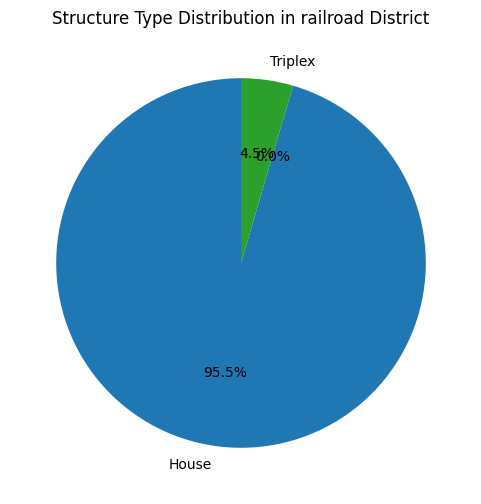

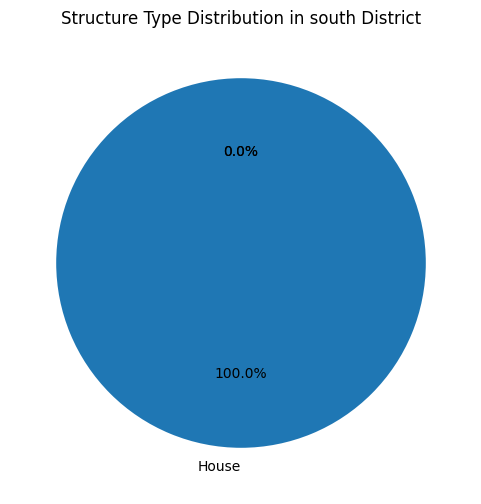

In [25]:
# Group by 'District' and 'Property Type', then count the number of properties
property_count = slo_re.groupby(['District', 'Structure Type']).size().unstack(fill_value=0)

# Plot pie charts for each district
for district in property_count.index:
    property_count.loc[district].plot.pie(
        autopct='%1.1f%%',
        startangle=90,
        title=f'Structure Type Distribution in {district} District',
        ylabel='',  # Hide the y-label for better appearance
        figsize=(6, 6)
    )
    plt.show()

In [26]:
property_count

Structure Type,House,Multi-Family,Triplex
District,,,
downtown,16,0,1
foothill,24,0,0
laguna,19,4,1
lobro,20,4,0
lohi,23,1,0
mojo,11,0,0
railroad,21,0,1
south,11,0,0


Summary statistics of listings by district

In [27]:
summary_stats = slo_re.groupby('District').agg({
    'Sell Price': ['mean', 'median', 'max', 'min'],
    'MLS #': 'count',
    'Price per/Sqft': ['mean', 'median'],
    'Lot Size': ['mean', 'max', 'min'],
    'Beds': 'mean',
    'Baths': 'mean'
}).rename(columns={'count': 'Total Properties'})

# Flatten column hierarchy
summary_stats.columns = ['Average Price', 'Median Price','Max Price', 'Min Price', 'Total Properties', 'Average Price per Sqft',
                         'Median Price Per Sqft', 'Average Lot Size', 'Max Lot Size', 'Min Lot Size', 'Average Beds', 'Average Baths']

# Display the result
print(summary_stats)

          Average Price  Median Price  Max Price  Min Price  Total Properties  \
District                                                                        
downtown   1.128267e+06      999000.0    2395000     525000                17   
foothill   1.207640e+06     1154500.0    1940000     635000                24   
laguna     1.060706e+06      810250.0    4713000     440000                24   
lobro      1.147775e+06     1160000.0    2900000     400000                24   
lohi       9.264750e+05      755750.0    1511000     400000                24   
mojo       1.645455e+06     1530000.0    2900000     880000                11   
railroad   1.274631e+06     1137500.0    2900000     625000                22   
south      8.115600e+05      810000.0    1175000     427575                11   

          Average Price per Sqft  Median Price Per Sqft  Average Lot Size  \
District                                                                    
downtown              802.013937   

Box plots for distribution of price by district

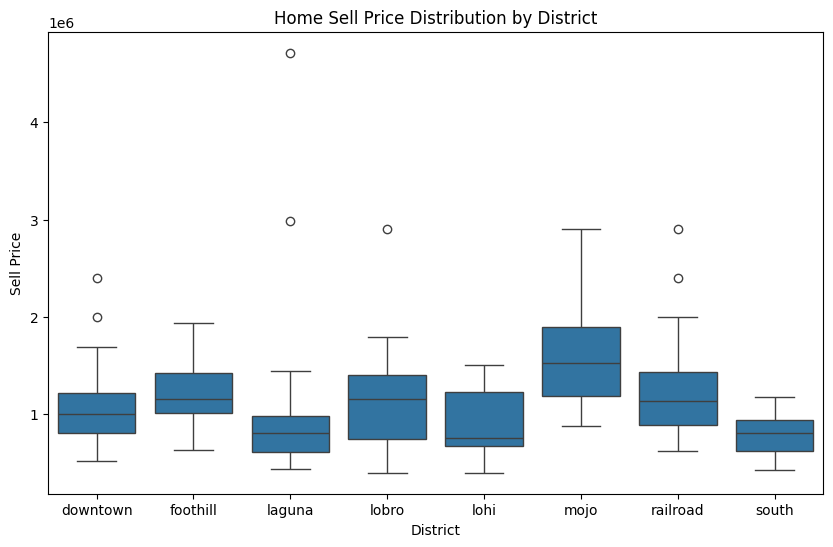

In [28]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='District', y='Sell Price', data=slo_re)
plt.title('Home Sell Price Distribution by District')
plt.xlabel('District')
plt.ylabel('Sell Price')
plt.show()

In [29]:
# Test for difference in price by district

model = smf.ols('Q("Sell Price") ~ C(District)', data=slo_re).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

# Print the ANOVA table
print(anova_table)

                   sum_sq     df        F    PR(>F)
C(District)  5.752769e+12    7.0  2.60482  0.014518
Residual     4.700970e+13  149.0      NaN       NaN


In [30]:
# Average difference in List Price vs Sale Price by district (In percentages)
mean_price_diff = (slo_re.groupby('District')['Price Difference'].mean() - 1) * 100
mean_price_diff

,Price Difference
District,
downtown,-0.197081
foothill,-0.399565
laguna,0.579972
lobro,-3.874271
lohi,-3.067430
mojo,-1.904472
railroad,-1.356792
south,-0.121278


# Exploratory Analysis Time Series


In [31]:
slo_re['Closed On']

,Closed On
0,2024-07-26
1,2024-07-25
2,2024-07-19
3,2024-07-11
4,2024-06-24
...,...
152,2024-05-24
153,2024-04-19
154,2024-04-17
155,2024-04-03


In [32]:
slo_re_time = slo_re
slo_re_time['Closed On'] = pd.to_datetime(slo_re_time['Closed On'])
slo_re_time['Price per/Sqft']

,Price per/Sqft
0,722.766885
1,898.069151
2,995.833333
3,810.000000
4,1181.818182
...,...
152,582.660037
153,568.498717
154,702.289377
155,702.289377


In [33]:
daily_avg_price = slo_re_time.groupby('Closed On')['Price per/Sqft'].mean().reset_index()

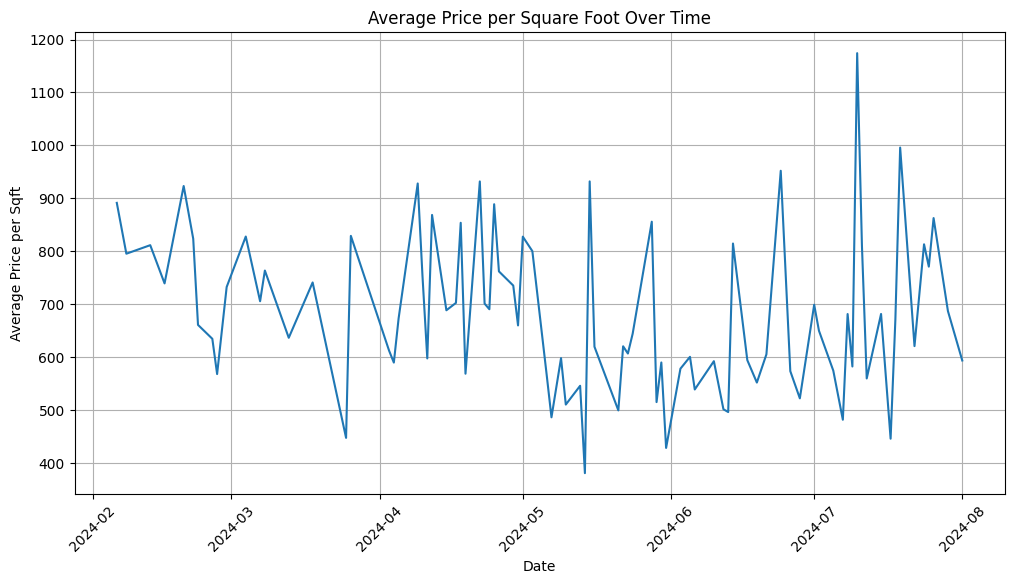

In [34]:
# Daily Average Prices
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_avg_price, x='Closed On', y='Price per/Sqft')
plt.title('Average Price per Square Foot Over Time')
plt.xlabel('Date')
plt.ylabel('Average Price per Sqft')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [35]:
weekly_avg_price = slo_re_time.set_index('Closed On').resample('W')['Price per/Sqft'].mean().reset_index()

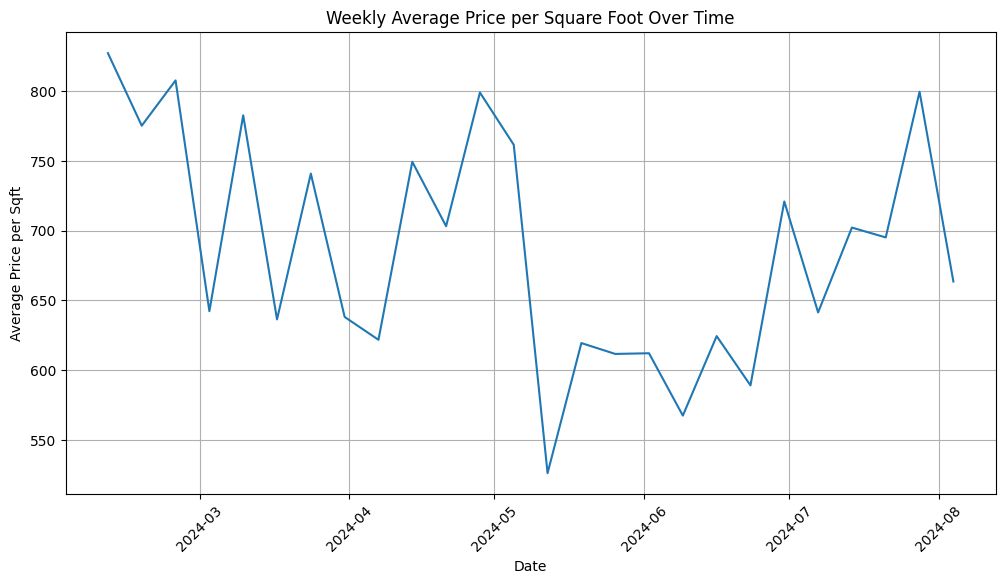

In [36]:
# Weekly Average Price per Sqft
plt.figure(figsize=(12, 6))
sns.lineplot(data=weekly_avg_price, x='Closed On', y='Price per/Sqft')
plt.title('Weekly Average Price per Square Foot Over Time')
plt.xlabel('Date')
plt.ylabel('Average Price per Sqft')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

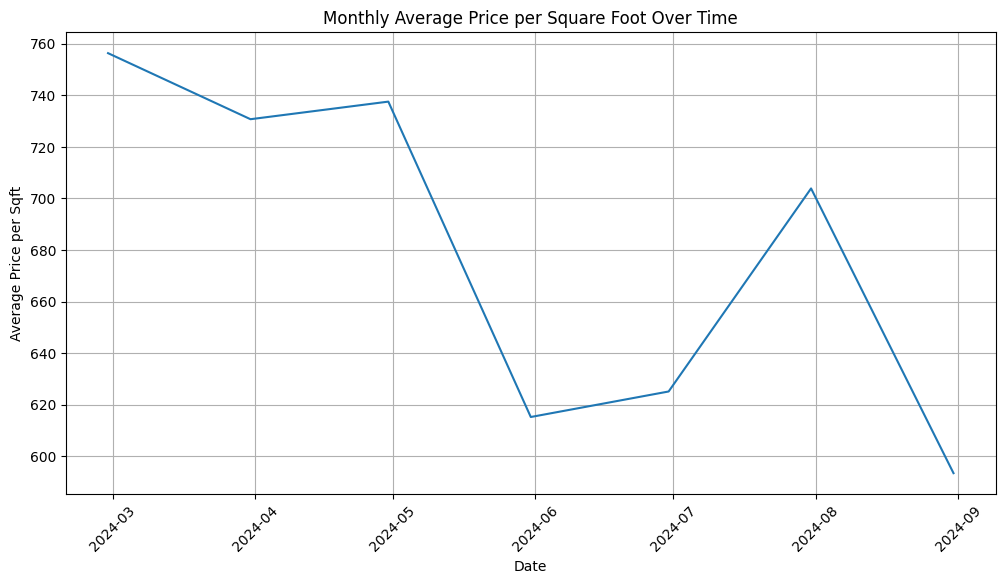

In [37]:
# Monthly average price per sqft
monthly_avg_price = slo_re_time.set_index('Closed On').resample('M')['Price per/Sqft'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_avg_price, x='Closed On', y='Price per/Sqft')
plt.title('Monthly Average Price per Square Foot Over Time')
plt.xlabel('Date')
plt.ylabel('Average Price per Sqft')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [38]:
# Average List price vs Sell Price
daily_avg_list_price = slo_re_time.groupby('Closed On')['List Price'].mean().reset_index()
daily_avg_sell_price = slo_re_time.groupby('Closed On')['Sell Price'].mean().reset_index()

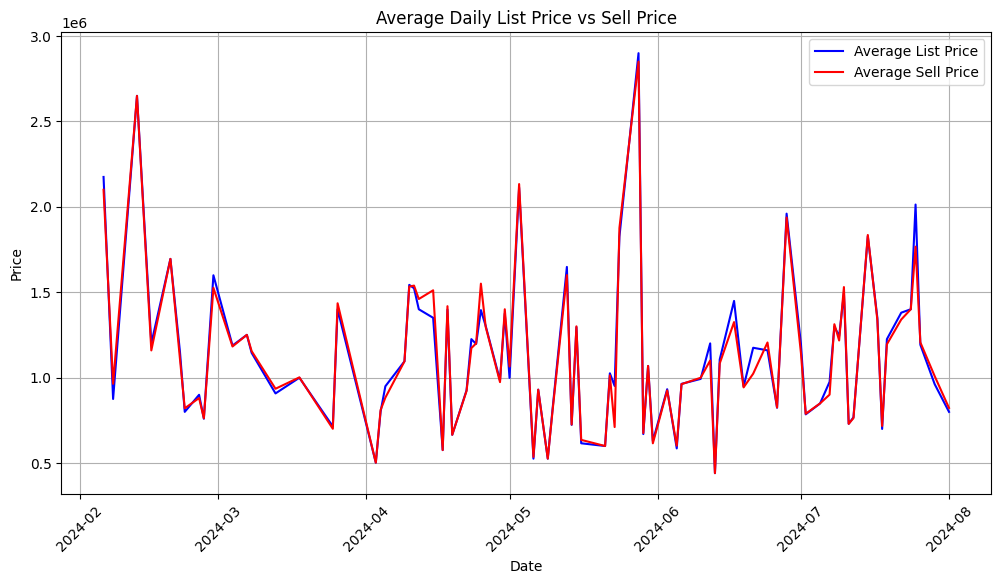

In [39]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=daily_avg_list_price, x='Closed On', y='List Price', color='blue', label='Average List Price')
sns.lineplot(data=daily_avg_sell_price, x='Closed On', y='Sell Price', color='red', label='Average Sell Price')

plt.title('Average Daily List Price vs Sell Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()


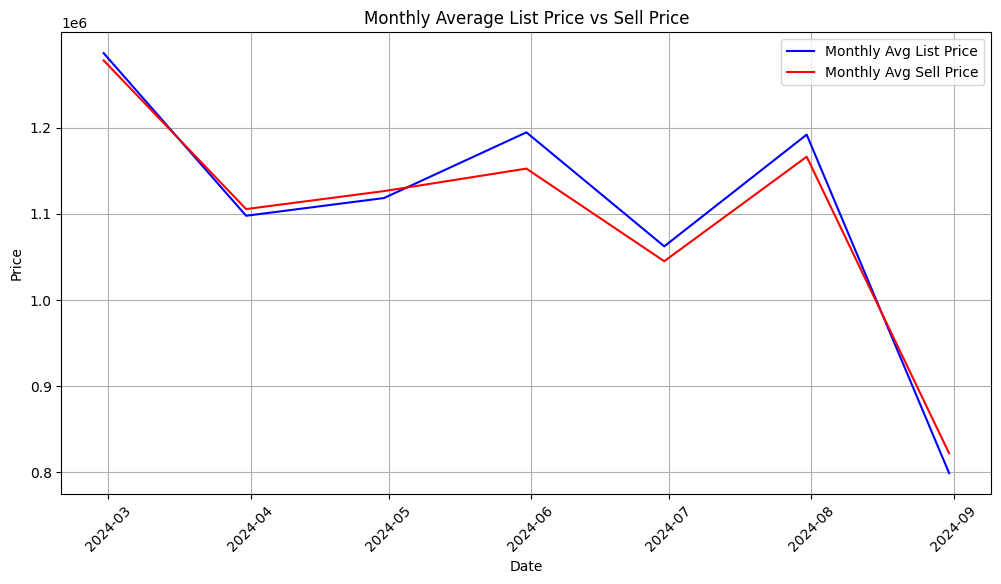

In [40]:
# Calculate monthly average list price
monthly_avg_list_price = slo_re_time.set_index('Closed On')['List Price'].resample('M').mean().reset_index()

# Calculate monthly average sell price
monthly_avg_sell_price = slo_re_time.set_index('Closed On')['Sell Price'].resample('M').mean().reset_index()

plt.figure(figsize=(12, 6))

# Plot monthly average list price in blue
sns.lineplot(data=monthly_avg_list_price, x='Closed On', y='List Price', color='blue', label='Monthly Avg List Price')

# Plot monthly average sell price in red
sns.lineplot(data=monthly_avg_sell_price, x='Closed On', y='Sell Price', color='red', label='Monthly Avg Sell Price')

plt.title('Monthly Average List Price vs Sell Price')
plt.xlabel('Date')
plt.ylabel('Price')
y_ticks = np.arange(800000, 1300000, 100000)
plt.yticks(y_ticks)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()


# Predictive Models for Sell Price - Linear Regression and KNN

In [41]:
slo_re_anova_price = slo_re.dropna(subset=['Lot Size', 'Latitude', 'Longitude', 'Year Built', 'New Construction', 'Attached Garage',
                                     'Stories', 'Garage Spaces', 'HOA Fee', 'Lot Size', 'Square Footage', 'Baths', 'Beds',
                                     'Structure Type', 'List Price', 'Days On Market'])

In [42]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

# Anova test for evaluating predictor variables on 'Sell Price'
categorical_vars = ['New Construction', 'Attached Garage', 'Stories', 'Structure Type', 'Beds', 'Baths']
for var in categorical_vars:
    slo_re_anova_price.loc[:, var] = slo_re_anova_price[var].astype('category')

formula = 'Q("Days On Market") ~ Q("List Price") + Q("Square Footage") + Q("Lot Size") + Q("Latitude") + Q("Longitude") + Q("Year Built") + C(Q("New Construction")) + C(Q("Attached Garage")) + C(Q("Stories")) + Q("Garage Spaces") + Q("HOA Fee") + C(Q("Beds")) + C(Q("Baths")) + C(Q("Structure Type")) + Q("Days On Market")'

model = smf.ols(formula=formula, data=slo_re_anova_price).fit()

anova_results = anova_lm(model, typ=2)
print(anova_results)

                                sum_sq    df             F    PR(>F)
C(Q("New Construction"))  5.748732e-29   1.0  3.634699e-06  0.998484
C(Q("Attached Garage"))   2.011491e-27   1.0  1.271787e-04  0.991031
C(Q("Stories"))           1.240055e-26   4.0  1.960096e-04  1.000000
C(Q("Beds"))              1.249095e-26   5.0  1.579508e-04  1.000000
C(Q("Baths"))             7.799387e-27   7.0  7.044640e-05  1.000000
C(Q("Structure Type"))    1.302599e-27   2.0  4.117913e-05  0.999959
Q("List Price")           1.205253e-24   1.0  7.620345e-02  0.783249
Q("Square Footage")       6.529060e-27   1.0  4.128070e-04  0.983843
Q("Lot Size")             2.642502e-27   1.0  1.670751e-04  0.989720
Q("Latitude")             1.980555e-29   1.0  1.252228e-06  0.999110
Q("Longitude")            2.941707e-28   1.0  1.859927e-05  0.996570
Q("Year Built")           3.603241e-28   1.0  2.278189e-05  0.996204
Q("Garage Spaces")        2.232724e-28   1.0  1.411665e-05  0.997012
Q("HOA Fee")              5.011883

NaN handling for Condiminum Property Types. (Condos do not have listed lot sizes)

In [43]:
# Pre Processing Size Verification
slo_re.groupby(['District', 'Structure Type']).size().unstack(fill_value=0)

Structure Type,House,Multi-Family,Triplex
District,,,
downtown,16,0,1
foothill,24,0,0
laguna,19,4,1
lobro,20,4,0
lohi,23,1,0
mojo,11,0,0
railroad,21,0,1
south,11,0,0


In [44]:
slo_re.groupby('District').size()

,0
District,
downtown,17
foothill,24
laguna,24
lobro,24
lohi,24
mojo,11
railroad,22
south,11


In [45]:
# Drop rows where 'Property Type' is NaN
slo_re_regression = slo_re.dropna(subset=['Lot Size', 'Latitude', 'Longitude'])

# Group by 'District' and 'Property Type', then count the number of properties
property_count = slo_re_regression.groupby(['District', 'Structure Type']).size().unstack(fill_value=0)
property_count

Structure Type,House,Multi-Family,Triplex
District,,,
downtown,16,0,1
foothill,23,0,0
laguna,18,2,1
lobro,16,3,0
lohi,21,1,0
mojo,11,0,0
railroad,21,0,1
south,9,0,0


In [46]:
slo_re_regression.groupby('District').size()

,0
District,
downtown,17
foothill,23
laguna,21
lobro,19
lohi,22
mojo,11
railroad,22
south,9


Linear Regression Model for Price Predictions

In [47]:
slo_re_regression.head()

,MLS #,List Price,Sell Price,Address,Structure Type,Property Type,Beds,Full Baths,Half Baths,Square Footage,...,Year Built,Common Interest,Days On Market,District,Price Difference,Cleaned Address,Latitude,Longitude,Price per/Sqft,Baths
0,MLS #SC24127762,663500,663500,"570 Peach Street #23 San Luis Obispo, CA 93401...",House,Residential,2,2.0,0,918,...,1975,Condominium,4.0,downtown,1.000000,570 Peach Street San Luis Obispo,35.281432,-120.667350,722.766885,2.0
1,MLS #SC24091640,2195000,2000000,"570 Pacific San Luis Obispo, CA 93401",House,Residential,3,3.0,1,2227,...,2024,NaN,57.0,downtown,0.911162,570 Pacific San Luis Obispo,35.280136,-120.658902,898.069151,3.5
2,MLS #SC24073717,1225000,1195000,"771 Toro Street San Luis Obispo, CA 93401-2830",House,Residential,2,2.0,0,1200,...,1925,NaN,68.0,downtown,0.975510,771 Toro Street San Luis Obispo,35.285476,-120.660686,995.833333,2.0
3,MLS #NS24109649,729000,729000,"1739 Johnson Avenue San Luis Obispo, CA 93401-...",House,Residential,2,1.0,0,900,...,1925,NaN,8.0,downtown,1.000000,1739 Johnson Avenue San Luis Obispo,35.279243,-120.650931,810.000000,1.0
4,MLS #SC23208408,1194000,1300000,"1143 Peach Street San Luis Obispo, CA 93401-2818",House,Residential,2,2.0,0,1100,...,1906,NaN,143.0,downtown,1.088777,1143 Peach Street San Luis Obispo,35.285429,-120.661198,1181.818182,2.0


In [48]:
# Uses Coordinates, Beds, Baths, Square Footage, Lot Size, District, and Property Type as predictors

X = slo_re_regression[['Latitude', 'Longitude', 'Beds', 'Baths', 'Square Footage', 'Lot Size', 'District', 'Structure Type']]
y = slo_re_regression['Sell Price']

'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LinearRegression()
model.fit(X_train, y_train)

ct = make_column_transformer(
    (StandardScaler(), ['Beds', 'Baths', 'Square Footage', 'Lot Size']),
    (OneHotEncoder(), ['District', 'Property Type']),
    remainder="passthrough"
)
ct

pipeline = make_pipeline(
    ct,
    LinearRegression()
)

lrModel = pipeline.fit(X=X_train,
             y=y_train)
'''

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the column transformer
ct = make_column_transformer(
    (Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
        ('scaler', StandardScaler())
    ]), ['Beds', 'Baths', 'Square Footage', 'Lot Size']),
    (Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Impute missing categorical values
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), ['District', 'Structure Type']),
    remainder="passthrough"
)

pipeline = make_pipeline(
    ct,
    LinearRegression()
)

lrModel = pipeline.fit(X_train, y_train)

y_pred = lrModel.predict(X_test)

In [49]:
# Model Results
lrModel_reg = lrModel.named_steps['linearregression']

y_pred = lrModel.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

LMCoef = lrModel_reg.coef_
LMInter = lrModel_reg.intercept_

print("Linear Regression Model Parameters - ", "Coefficients: ", LMCoef, " Model Intercept: ", LMInter, "\n")

print("Mean Squared Error: ", mse)
print("R^2 Score: ", r2)

Linear Regression Model Parameters -  Coefficients:  [  -94457.59245489    95800.15472925   417070.48196789   262510.29533006
    64226.64915609    98965.73077125  -230040.71532775  -196703.6711375
  -146738.27320339   414126.55553467   209628.57857046  -213464.85436383
    68159.25907987  -115551.30411681    47392.04503694   346023.62882092
 -3039200.03889209]  Model Intercept:  -377827899.6572399 

Mean Squared Error:  91383970080.44257
R^2 Score:  0.45220010465491


In [50]:
# Accuracy Testing - Assess how often predictions were within x% of actual price

percentage_deviation = 0.10
within_range_count = sum(abs(y_test.values - y_pred) / y_test.values <= percentage_deviation)

print("Number of predictions within ±10% of the actual price: ", within_range_count)
print("Total number of predictions: ", len(y_test))
print("Percentage of predictions within ±10%: {:.2f}%".format((within_range_count / len(y_test)) * 100))

Number of predictions within ±10% of the actual price:  7
Total number of predictions:  29
Percentage of predictions within ±10%: 24.14%


KNN Model for Price Predictions

,0
1,1.629064e+11
9,1.780689e+11
8,1.837826e+11
4,1.840722e+11
7,1.851978e+11
6,1.867122e+11
5,1.872894e+11
2,2.019874e+11
3,2.129052e+11


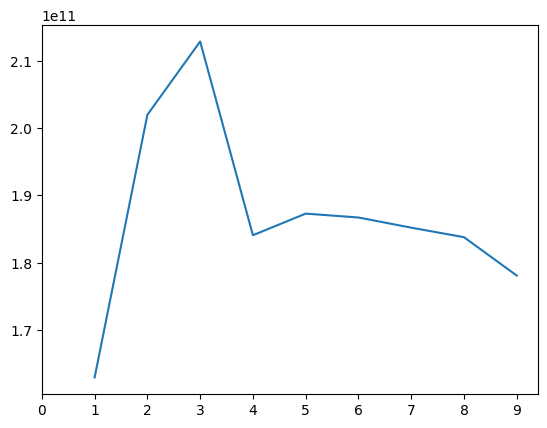

In [51]:
#lrModel = pipeline.fit(X=X_train,
 #            y=y_train)

# Hyperparameter Tuning for KNN Model

def get_cv_error(k):
  knn_model = make_pipeline(
      ct,
      KNeighborsRegressor(n_neighbors=k)
  )

  cv_errs = -cross_val_score(knn_model, X=X_train, y=y_train,
                             scoring="neg_mean_squared_error", cv=10)
  return cv_errs.mean()

ks = pd.Series(range(1, 10))
ks.index = range(1, 10)
test_errs = ks.apply(get_cv_error)

test_errs.plot.line(xticks=range(0,10))
test_errs.sort_values()

In [52]:
pipeline = make_pipeline(
    ct,
    KNeighborsRegressor(n_neighbors=9)
)

knnModel = pipeline.fit(X=X_train,
             y=y_train)

In [53]:
# Model Results
#knnModel_reg = knnModel.named_steps['knnregressor']

y_pred = knnModel.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

#knnCoef = knnModel_reg.coef_
#knnInter = knnModel_reg.intercept_

#print("Linear Regression Model Parameters - ", "Coefficients: ", LMCoef, " Model Intercept: ", LMInter, "\n")

print("Mean Squared Error: ", mse)
print("R^2 Score: ", r2)

Mean Squared Error:  101015309615.7288
R^2 Score:  0.39446517822505056


In [54]:

# Accuracy Testing - Assess how often predictions were within x% of actual price

percentage_deviation = 0.1
within_range_count = sum(abs(y_test.values - y_pred) / y_test.values <= percentage_deviation)

print("Number of predictions within ±10% of the actual price: ", within_range_count)
print("Total number of predictions: ", len(y_test))
print("Percentage of predictions within ±10%: {:.2f}%".format((within_range_count / len(y_test)) * 100))

Number of predictions within ±10% of the actual price:  10
Total number of predictions:  29
Percentage of predictions within ±10%: 34.48%


# Geographical Analysis


In [55]:
slo_re.head()

,MLS #,List Price,Sell Price,Address,Structure Type,Property Type,Beds,Full Baths,Half Baths,Square Footage,...,Year Built,Common Interest,Days On Market,District,Price Difference,Cleaned Address,Latitude,Longitude,Price per/Sqft,Baths
0,MLS #SC24127762,663500,663500,"570 Peach Street #23 San Luis Obispo, CA 93401...",House,Residential,2,2.0,0,918,...,1975,Condominium,4.0,downtown,1.000000,570 Peach Street San Luis Obispo,35.281432,-120.667350,722.766885,2.0
1,MLS #SC24091640,2195000,2000000,"570 Pacific San Luis Obispo, CA 93401",House,Residential,3,3.0,1,2227,...,2024,NaN,57.0,downtown,0.911162,570 Pacific San Luis Obispo,35.280136,-120.658902,898.069151,3.5
2,MLS #SC24073717,1225000,1195000,"771 Toro Street San Luis Obispo, CA 93401-2830",House,Residential,2,2.0,0,1200,...,1925,NaN,68.0,downtown,0.975510,771 Toro Street San Luis Obispo,35.285476,-120.660686,995.833333,2.0
3,MLS #NS24109649,729000,729000,"1739 Johnson Avenue San Luis Obispo, CA 93401-...",House,Residential,2,1.0,0,900,...,1925,NaN,8.0,downtown,1.000000,1739 Johnson Avenue San Luis Obispo,35.279243,-120.650931,810.000000,1.0
4,MLS #SC23208408,1194000,1300000,"1143 Peach Street San Luis Obispo, CA 93401-2818",House,Residential,2,2.0,0,1100,...,1906,NaN,143.0,downtown,1.088777,1143 Peach Street San Luis Obispo,35.285429,-120.661198,1181.818182,2.0


In [56]:
slo_re.columns

Index(['MLS #', 'List Price', 'Sell Price', 'Address', 'Structure Type',
       'Property Type', 'Beds', 'Full Baths', 'Half Baths', 'Square Footage',
       'Lot Size', 'HOA Fee', 'Parking Spots', 'Garage Spaces', 'Closed On',
       'Stories', 'Style', 'Attached Garage', 'Road Frontage',
       'New Construction', 'Year Built', 'Common Interest', 'Days On Market',
       'District', 'Price Difference', 'Cleaned Address', 'Latitude',
       'Longitude', 'Price per/Sqft', 'Baths'],
      dtype='object')

In [57]:
slo_re_map = slo_re.dropna(subset=['Latitude', 'Longitude'])

In [58]:
# Heat map of listing based on price/sqft
m = folium.Map(location=[slo_re_map['Latitude'].mean(), slo_re_map['Longitude'].mean()], zoom_start=12, tiles= 'OpenStreetMap')

heat_data = [[row['Latitude'], row['Longitude'], row['Price per/Sqft']] for idx, row in slo_re_map.iterrows()]
HeatMap(heat_data).add_to(m)

for idx, row in slo_re_map.iterrows():
    folium.Circle(
        location=(row['Latitude'], row['Longitude']),
        radius=50,
        color='blue',
        fill=True,
        fill_opacity=0.6,
        popup=f"Price per sqft: {row['Price per/Sqft']}"
    ).add_to(m)

#m.save('map.html')
m

<Axes: xlabel='Latitude', ylabel='Longitude'>

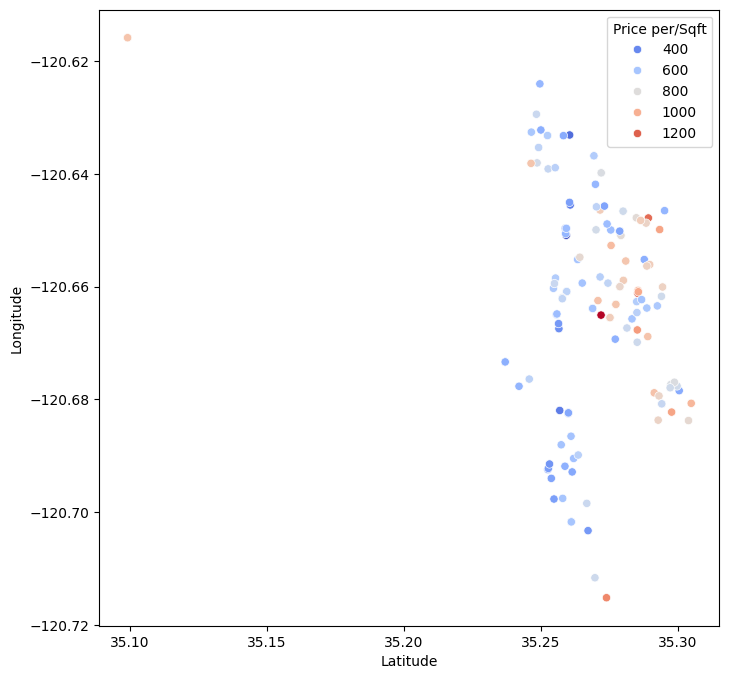

In [59]:
# Basic mapping of price/sqft
plt.figure(figsize=(8, 8))
sns.scatterplot(x='Latitude', y='Longitude', data= slo_re_map, hue='Price per/Sqft', palette= 'coolwarm')

In [60]:
# Price per/sqft map w/ optional heat map
price_min, price_max = slo_re_map['Price per/Sqft'].min(), slo_re_map['Price per/Sqft'].max()
size_min, size_max = slo_re_map['Square Footage'].min(), slo_re_map['Square Footage'].max()

m2 = folium.Map(location=[slo_re_map['Latitude'].mean(), slo_re_map['Longitude'].mean()], zoom_start=12, tiles= 'OpenStreetMap')

#heat_data = [[row['Latitude'], row['Longitude'], row['Price per/Sqft']] for idx, row in slo_re_map.iterrows()]
#HeatMap(heat_data).add_to(m2)

for idx, row in slo_re_map.iterrows():

    norm_price = (row['Price per/Sqft'] - price_min) / (price_max - price_min)
    norm_size = (row['Square Footage'] - size_min) / (size_max - size_min)
    color = plt.cm.RdYlGn(1 - norm_price)

    popup_info = f'''
                    Address: {row["Address"]}<br>
                    District: {row["District"]}<br>
                    Structure Type: {row["Structure Type"]}<br>
                    Beds: {row['Beds']}<br>
                    Baths: {row['Baths']}<br>
                    Sold On: {row['Closed On']}<br>
                    Sale Price: {row['Sell Price']}<br>
                    Price per/Sqft: {row["Price per/Sqft"]}<br>
                    Square Footage: {row["Square Footage"]}<br>
                    Days on Market: {row['Days On Market']}'''

    folium.CircleMarker(
        location=(row['Latitude'], row['Longitude']),
        radius= 15 + norm_size * 20,
        color= mcolors.to_hex(color[:3]),
        fill=True,
        fill_color= mcolors.to_hex(color[:3]),
        fill_opacity=0.8,
        popup= folium.Popup(popup_info, max_width=300)
    ).add_to(m2)

#m2.save('price_per_sqft_map.html')
m2

In [61]:
# Days on Market map w/ optional heat map
slo_re_map['log_Days On Market'] = np.log1p(slo_re_map['Days On Market'])

dom_min, dom_max = slo_re_map['log_Days On Market'].min(), slo_re_map['log_Days On Market'].max()
size_min, size_max = slo_re_map['Square Footage'].min(), slo_re_map['Square Footage'].max()

m3 = folium.Map(location=[slo_re_map['Latitude'].mean(), slo_re_map['Longitude'].mean()], zoom_start=12, tiles= 'OpenStreetMap')

#heat_data = [[row['Latitude'], row['Longitude'], row['Price per/Sqft']] for idx, row in slo_re_map.iterrows()]
#HeatMap(heat_data).add_to(m3)

for idx, row in slo_re_map.iterrows():

    norm_dom = (row['log_Days On Market'] - dom_min) / (dom_max - dom_min)
    norm_size = (row['Square Footage'] - size_min) / (size_max - size_min)
    color = plt.cm.RdYlGn(1 - norm_dom)

    popup_info = f'''
                    Address: {row["Address"]}<br>
                    District: {row["District"]}<br>
                    Structure Type: {row["Structure Type"]}<br>
                    Beds: {row['Beds']}<br>
                    Baths: {row['Baths']}<br>
                    Sold On: {row['Closed On']}<br>
                    Sale Price: {row['Sell Price']}<br>
                    Price per/Sqft: {row["Price per/Sqft"]}<br>
                    Square Footage: {row["Square Footage"]}<br>
                    Days on Market: {row['Days On Market']}'''

    folium.CircleMarker(
        location=(row['Latitude'], row['Longitude']),
        radius= 15 + norm_size * 20,
        color= mcolors.to_hex(color[:3]),
        fill=True,
        fill_color= mcolors.to_hex(color[:3]),
        fill_opacity=0.7,
        popup= folium.Popup(popup_info, max_width=300)
    ).add_to(m3)

m3.save('days_on_market_map.html')
#m3

<ipython-input-61-1df1253ad5cb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slo_re_map['log_Days On Market'] = np.log1p(slo_re_map['Days On Market'])


# Predictive Modeling for Days On Market Elementary Exploration


In [62]:
slo_re.columns

Index(['MLS #', 'List Price', 'Sell Price', 'Address', 'Structure Type',
       'Property Type', 'Beds', 'Full Baths', 'Half Baths', 'Square Footage',
       'Lot Size', 'HOA Fee', 'Parking Spots', 'Garage Spaces', 'Closed On',
       'Stories', 'Style', 'Attached Garage', 'Road Frontage',
       'New Construction', 'Year Built', 'Common Interest', 'Days On Market',
       'District', 'Price Difference', 'Cleaned Address', 'Latitude',
       'Longitude', 'Price per/Sqft', 'Baths'],
      dtype='object')

In [63]:
slo_re.columns

Index(['MLS #', 'List Price', 'Sell Price', 'Address', 'Structure Type',
       'Property Type', 'Beds', 'Full Baths', 'Half Baths', 'Square Footage',
       'Lot Size', 'HOA Fee', 'Parking Spots', 'Garage Spaces', 'Closed On',
       'Stories', 'Style', 'Attached Garage', 'Road Frontage',
       'New Construction', 'Year Built', 'Common Interest', 'Days On Market',
       'District', 'Price Difference', 'Cleaned Address', 'Latitude',
       'Longitude', 'Price per/Sqft', 'Baths'],
      dtype='object')

In [64]:
slo_re_anova = slo_re.dropna(subset=['Lot Size', 'Latitude', 'Longitude', 'Year Built', 'New Construction', 'Attached Garage',
                                     'Stories', 'Garage Spaces', 'HOA Fee', 'Lot Size', 'Square Footage', 'Baths', 'Beds',
                                     'Structure Type', 'List Price', 'Days On Market'])

In [65]:
slo_re_anova2 = slo_re.dropna(subset=['Lot Size', 'Baths', 'List Price'])
slo_re_anova2.shape

(150, 30)

In [66]:
slo_re_anova['Days On Market'].median()

12.0

<Axes: >

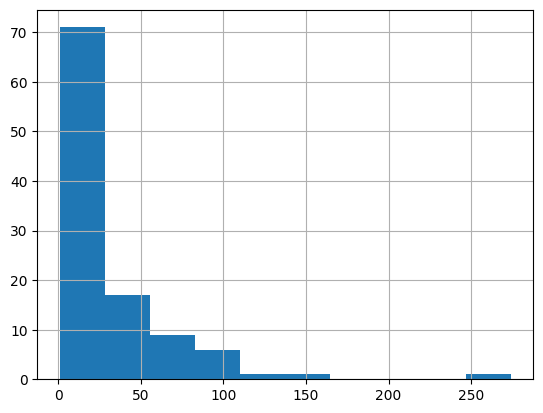

In [67]:
slo_re_anova['Days On Market'].hist(bins=10)

In [68]:
np.quantile(slo_re_anova['Days On Market'], 0.75) - np.quantile(slo_re_anova['Days On Market'], 0.25)

32.75

In [69]:
def days_mkt_category(days):
  if days <= 7:
    return 'fast'
  elif 7 < days <= 50:
    return 'average'
  elif 50 < days <= 100:
    return 'moderate'
  else:
    return 'slow'

slo_re_anova['Days Mkt Category'] = slo_re['Days On Market'].apply(days_mkt_category)
slo_re_anova

<ipython-input-69-04ec3e19201b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slo_re_anova['Days Mkt Category'] = slo_re['Days On Market'].apply(days_mkt_category)


,MLS #,List Price,Sell Price,Address,Structure Type,Property Type,Beds,Full Baths,Half Baths,Square Footage,...,Common Interest,Days On Market,District,Price Difference,Cleaned Address,Latitude,Longitude,Price per/Sqft,Baths,Days Mkt Category
1,MLS #SC24091640,2195000,2000000,"570 Pacific San Luis Obispo, CA 93401",House,Residential,3,3.0,1,2227,...,NaN,57.0,downtown,0.911162,570 Pacific San Luis Obispo,35.280136,-120.658902,898.069151,3.5,moderate
3,MLS #NS24109649,729000,729000,"1739 Johnson Avenue San Luis Obispo, CA 93401-...",House,Residential,2,1.0,0,900,...,NaN,8.0,downtown,1.000000,1739 Johnson Avenue San Luis Obispo,35.279243,-120.650931,810.000000,1.0,average
6,MLS #NS24075035,765000,765000,"415 Dana Street #1 San Luis Obispo, CA 93401-3403",House,Residential,2,1.0,1,1463,...,Condominium,5.0,downtown,1.000000,415 Dana Street San Luis Obispo,35.277171,-120.669327,522.898154,1.5,fast
10,MLS #SC24058703,1100000,1085000,"1328 Morro Street #110 San Luis Obispo, CA 93401",Triplex,Residential,2,1.0,0,1285,...,Condominium,10.0,downtown,0.986364,1328 Morro Street San Luis Obispo,35.278863,-120.660012,844.357977,1.0,average
12,MLS #PI24042321,799900,810000,"1144 Walnut Street #3 San Luis Obispo, CA 9340...",House,Residential,2,1.0,1,1374,...,Condominium,1.0,downtown,1.012627,1144 Walnut Street San Luis Obispo,35.286786,-120.662315,589.519651,1.5,fast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,MLS #SC24058886,935000,937500,"168 Earthwood Lane San Luis Obispo, CA 93401-9108",House,Residential,3,2.0,1,1609,...,Planned Development,39.0,south,1.002674,168 Earthwood Lane San Luis Obispo,35.237002,-120.673370,582.660037,2.5,average
153,MLS #SC23205858,664575,664575,"200 Earthwood Lane San Luis Obispo, CA 93401-9108",House,Residential,3,1.0,1,1169,...,Planned Development,1.0,south,1.000000,200 Earthwood Lane San Luis Obispo,35.237002,-120.673370,568.498717,1.5,fast
154,MLS #SC23204405,575175,575175,"164 Earthwood Lane San Luis Obispo, CA 93401",House,Residential,2,1.0,0,819,...,NaN,58.0,south,1.000000,164 Earthwood Lane San Luis Obispo,35.237002,-120.673370,702.289377,1.0,moderate
155,MLS #SC23209915,575175,575175,"192 Earthwood Lane San Luis Obispo, CA 93401",House,Residential,2,1.0,0,819,...,NaN,48.0,south,1.000000,192 Earthwood Lane San Luis Obispo,35.237002,-120.673370,702.289377,1.0,average


In [70]:
slo_re_anova['Days Mkt Category'].value_counts()

,count
Days Mkt Category,
average,51
fast,37
moderate,15
slow,3


In [71]:
def days_mkt_category_binary(days):
  if days <= 45:
    return 'average'
  else:
    return 'slow'

slo_re_anova['Days Mkt Category Binary'] = slo_re_anova['Days On Market'].apply(days_mkt_category_binary)
slo_re_anova['Days Mkt Category Binary'].value_counts()

<ipython-input-71-166d412acb12>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slo_re_anova['Days Mkt Category Binary'] = slo_re_anova['Days On Market'].apply(days_mkt_category_binary)


,count
Days Mkt Category Binary,
average,84
slow,22


In [72]:
slo_re_anova2['Days Mkt Category Binary'] = slo_re_anova2['Days On Market'].apply(days_mkt_category_binary)
slo_re_anova2['Days Mkt Category Binary'].value_counts()

<ipython-input-72-c7e788498892>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slo_re_anova2['Days Mkt Category Binary'] = slo_re_anova2['Days On Market'].apply(days_mkt_category_binary)


,count
Days Mkt Category Binary,
average,108
slow,42


<Axes: >

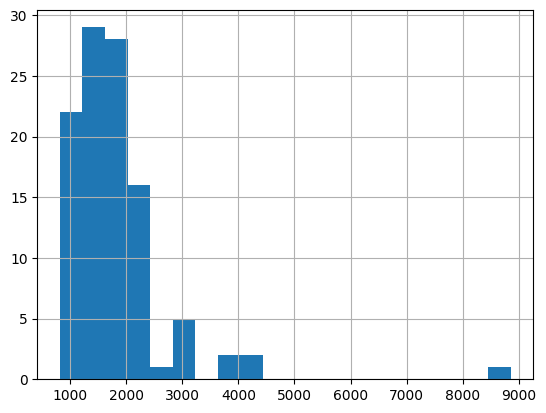

In [73]:
slo_re_anova['Square Footage'].hist(bins= 20)

<ipython-input-74-580b3ede10dd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slo_re_anova['Log Square Footage'] = np.log1p(slo_re_anova['Square Footage'])


<Axes: >

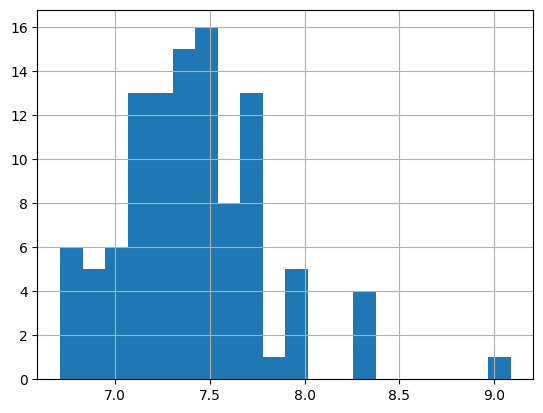

In [74]:
slo_re_anova['Log Square Footage'] = np.log1p(slo_re_anova['Square Footage'])
slo_re_anova['Log Square Footage'].hist(bins= 20)

<Axes: >

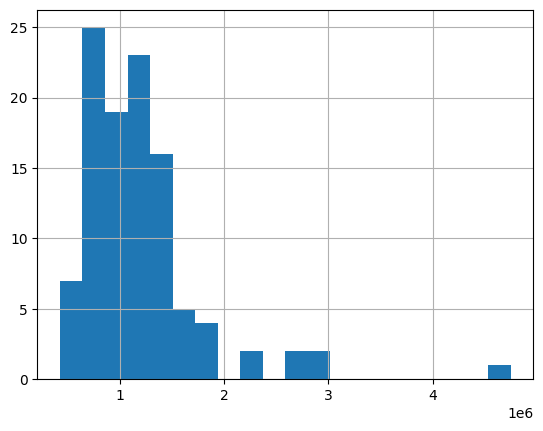

In [75]:
slo_re_anova['List Price'].hist(bins= 20)

<ipython-input-76-a2f8bc4e001c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slo_re_anova['Log List Price'] = np.log1p(slo_re_anova['List Price'])


<Axes: >

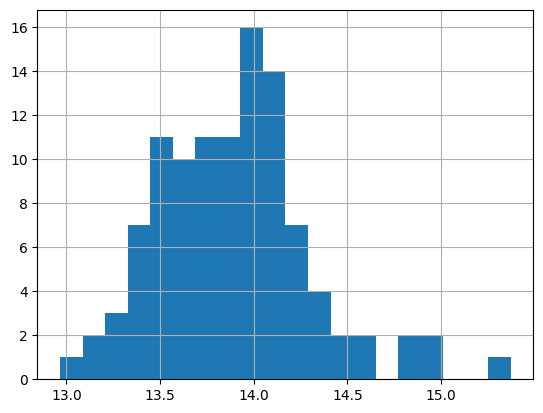

In [76]:
slo_re_anova['Log List Price'] = np.log1p(slo_re_anova['List Price'])
slo_re_anova['Log List Price'].hist(bins= 20)

<Axes: >

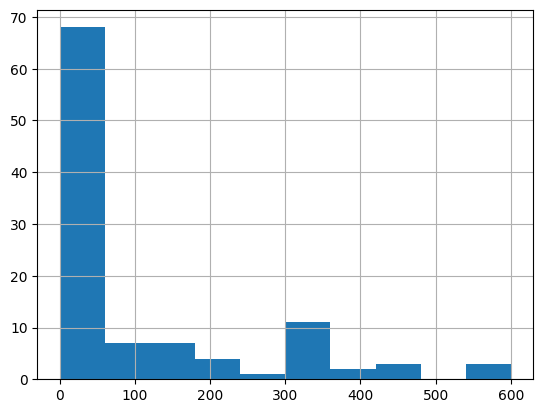

In [77]:
slo_re_anova['HOA Fee'].hist(bins=10)

<ipython-input-78-816d455144ed>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slo_re_anova['Log HOA Fee'] = np.log1p(slo_re_anova['HOA Fee'])


<Axes: >

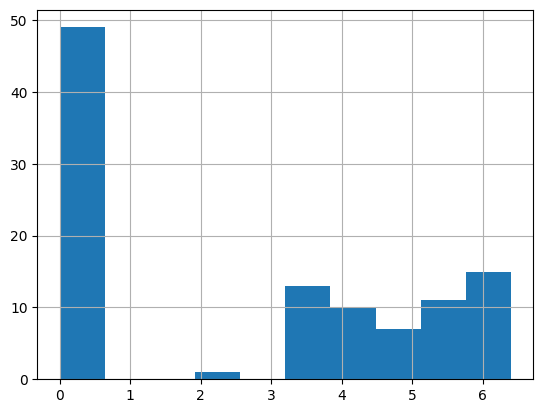

In [78]:
slo_re_anova['Log HOA Fee'] = np.log1p(slo_re_anova['HOA Fee'])
slo_re_anova['Log HOA Fee'].hist(bins=10)

<Axes: >

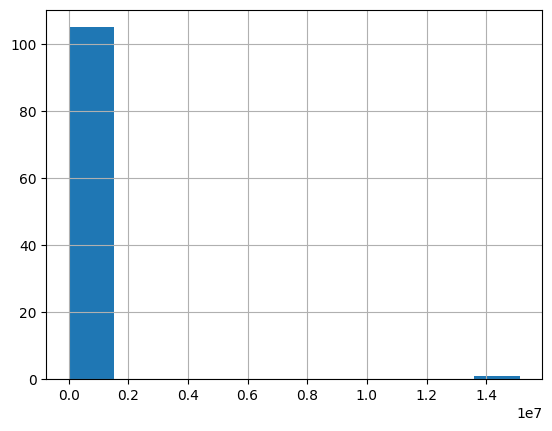

In [79]:
slo_re_anova['Lot Size'].hist(bins= 10)

<ipython-input-80-c01f83ef9800>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slo_re_anova['Log Lot Size'] = np.log1p(slo_re_anova['Lot Size'])


<Axes: >

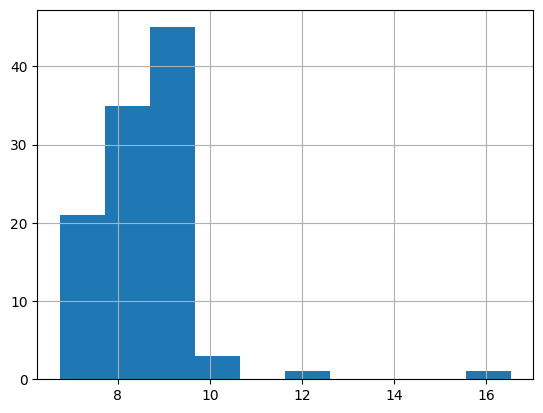

In [80]:
slo_re_anova['Log Lot Size'] = np.log1p(slo_re_anova['Lot Size'])
slo_re_anova['Log Lot Size'].hist(bins= 10)

<ipython-input-81-3fa35e455da1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slo_re_anova['SqRt Lot Size'] = np.sqrt(slo_re_anova['Log Lot Size'])


<Axes: >

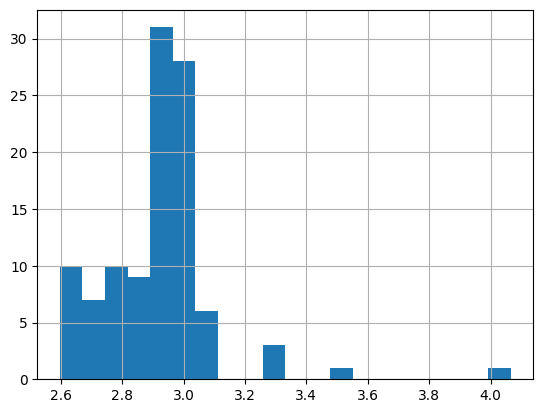

In [81]:
slo_re_anova['SqRt Lot Size'] = np.sqrt(slo_re_anova['Log Lot Size'])
slo_re_anova['SqRt Lot Size'].hist(bins= 20)

<Axes: >

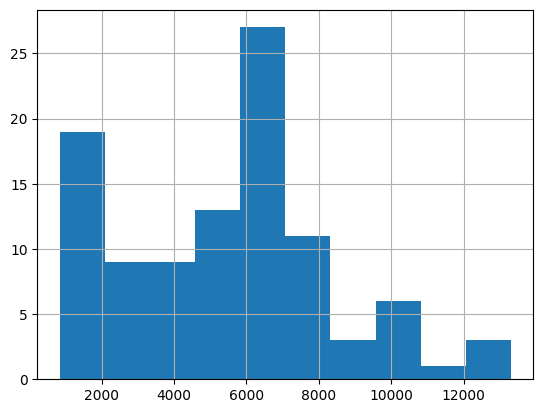

In [82]:
slo_re_anova_filtered = slo_re_anova[slo_re_anova['Lot Size'] <= 40000]
slo_re_anova_filtered['Lot Size'].hist(bins=10)

<ipython-input-83-bdac8f5df30f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slo_re_anova_filtered['Log Lot Size'] = np.log1p(slo_re_anova_filtered['Lot Size'])


<Axes: >

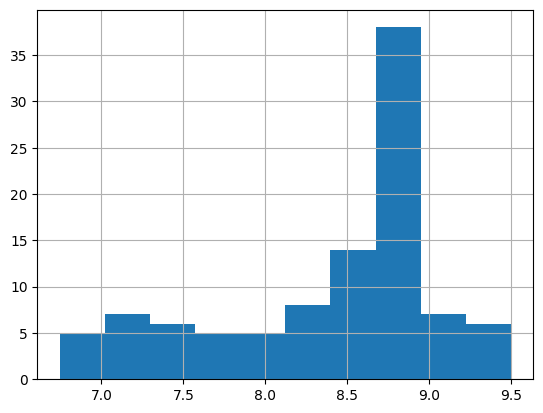

In [83]:
slo_re_anova_filtered['Log Lot Size'] = np.log1p(slo_re_anova_filtered['Lot Size'])
slo_re_anova_filtered['Log Lot Size'].hist(bins=10)

# Quantitative Predictive Modeling Exploration for Days On Market

In [84]:
# Anova test for evaluating predictor variables on 'Days On Market'
categorical_vars = ['New Construction', 'Attached Garage', 'Stories', 'Structure Type', 'Beds', 'Baths']
for var in categorical_vars:
    slo_re_anova.loc[:, var] = slo_re_anova[var].astype('category')

formula = 'Q("Days On Market") ~ Q("List Price") + Q("Square Footage") + Q("Lot Size") + Q("Latitude") + Q("Longitude") + Q("Year Built") + C(Q("New Construction")) + C(Q("Attached Garage")) + C(Q("Stories")) + Q("Garage Spaces") + Q("HOA Fee") + C(Q("Beds")) + C(Q("Baths")) + C(Q("Structure Type"))'

model = smf.ols(formula=formula, data=slo_re_anova).fit()

anova_results = anova_lm(model, typ=2)
print(anova_results)


                                sum_sq    df         F    PR(>F)
C(Q("New Construction"))   1494.334371   1.0  2.054639  0.155740
C(Q("Attached Garage"))    3486.798311   1.0  4.794183  0.031545
C(Q("Stories"))            7744.092243   4.0  2.661940  0.038666
C(Q("Beds"))              10004.579977   5.0  2.751165  0.024261
C(Q("Baths"))              8612.020200   7.0  1.691589  0.123277
C(Q("Structure Type"))     1116.278611   2.0  0.767415  0.467684
Q("List Price")             622.943767   1.0  0.856518  0.357569
Q("Square Footage")        3152.597055   1.0  4.334672  0.040623
Q("Lot Size")              3358.868094   1.0  4.618285  0.034734
Q("Latitude")                 7.286570   1.0  0.010019  0.920527
Q("Longitude")               11.223632   1.0  0.015432  0.901456
Q("Year Built")             526.216429   1.0  0.723523  0.397594
Q("Garage Spaces")         2267.500512   1.0  3.117706  0.081359
Q("HOA Fee")               2724.807353   1.0  3.746481  0.056543
Residual                 

In [85]:
slo_re_anova['Attached Garage'].dtype

dtype('O')

In [86]:
# Uses Attached Garage, Stories, Beds, Square Footage, Lot Size, HOA Fee as predictors for Days On Market

X = slo_re_anova[['Lot Size', 'List Price', 'Baths']]
y = slo_re_anova['Days On Market']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ct = make_column_transformer(
    (StandardScaler(), []),
    (OneHotEncoder(), ['Baths']),
    remainder="passthrough"
)
ct

pipeline = make_pipeline(
    ct,
    LinearRegression()
)

lrModel = pipeline.fit(X=X_train,
             y=y_train)

In [87]:
# Model Results
lrModel_reg = lrModel.named_steps['linearregression']

y_pred = lrModel.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

LMCoef = lrModel_reg.coef_
LMInter = lrModel_reg.intercept_

print("Linear Regression Model Parameters - ", "Coefficients: ", LMCoef, " Model Intercept: ", LMInter, "\n")

print("Mean Squared Error: ", mse)
print("R^2 Score: ", r2)

Linear Regression Model Parameters -  Coefficients:  [-7.44211780e+00 -1.26150710e+01  5.68216411e+00 -8.87149009e+00
 -1.18269595e+00  1.67626130e+01  1.31216903e+01 -5.45509264e+00
  1.40085917e-05  5.37425933e-06]  Model Intercept:  20.143359629873252 

Mean Squared Error:  885.8259728060752
R^2 Score:  0.07295500164733504


In [88]:
# Accuracy Testing - Assess how often predictions were within x% of actual price

percentage_deviation = 0.30
within_range_count = sum(abs(y_test.values - y_pred) / y_test.values <= percentage_deviation)

print("Number of predictions within ±10% of the actual price: ", within_range_count)
print("Total number of predictions: ", len(y_test))
print("Percentage of predictions within ±10%: {:.2f}%".format((within_range_count / len(y_test)) * 100))

Number of predictions within ±10% of the actual price:  7
Total number of predictions:  22
Percentage of predictions within ±10%: 31.82%


# KNN Classification Predictive Modeling for Days On Market

In [89]:
# 'Lot Size', 'List Price', 'Baths', 'Structure Type', 'Beds', 'Square Footage', 'HOA Fee', 'Stories', 'Attached Garage', 'New Construction' gives LOO F1 of mid 0.7's with 3 neighbors
# 'Log Lot Size', 'Log List Price', 'Baths', 'Structure Type', 'Beds', 'Log Square Footage', 'Log HOA Fee', 'Stories', 'Attached Garage', 'New Construction' gives LOO F1 of 0.82 with 5 neighbors
# 'Lot Size', 'List Price', 'Baths' gives LOO F1 of 0.566 with 3 neighbors

X = slo_re_anova[['Log Lot Size', 'Log List Price', 'Baths', 'Structure Type', 'Beds', 'Log Square Footage', 'Log HOA Fee', 'Stories', 'Attached Garage', 'New Construction']]
y = slo_re_anova['Days Mkt Category Binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ct = make_column_transformer(
    (StandardScaler(), ['Log Lot Size', 'Log List Price', 'Log Square Footage', 'Log HOA Fee']),
    (OneHotEncoder(handle_unknown="ignore"), ['Baths', 'Structure Type', 'Beds', 'Stories', 'Attached Garage', 'New Construction']),
    remainder="passthrough"
)
ct

pipeline = make_pipeline(
    ct,
    KNeighborsClassifier(n_neighbors=5)
)

class_lrModel = pipeline.fit(X=X_train,
             y=y_train)

y_pred = class_lrModel.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f1)

# Leave One Out Cross Validation
loo = LeaveOneOut()
scores = cross_val_score(pipeline, X, y, cv=loo, scoring='f1_weighted')

# Calculate the average F1 score
average_f1_score = scores.mean()
print("Average F1 Score (Leave-One-Out CV):", average_f1_score)

0.7332397332397332
Average F1 Score (Leave-One-Out CV): 0.8207547169811321


In [90]:
y_pred = class_lrModel.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
f1

0.7332397332397332

In [91]:
loo = LeaveOneOut()
scores = cross_val_score(pipeline, X, y, cv=loo, scoring='f1_weighted')

# Calculate the average F1 score
average_f1_score = scores.mean()
print("Average F1 Score (Leave-One-Out CV):", average_f1_score)

Average F1 Score (Leave-One-Out CV): 0.8207547169811321


# SVC Classification Predictive Modeling for Days On Market


In [92]:
'''
X = slo_re_anova[['Lot Size', 'List Price', 'Baths']]
y = slo_re_anova['Days Mkt Category']

ct = make_column_transformer(
    (StandardScaler(), []),
    (OneHotEncoder(handle_unknown="ignore"), ['Baths']),
    remainder="passthrough"
)

pipeline = make_pipeline(
    ct,
    SVC(kernel='linear', C=1.0, gamma='scale')
)

loo = LeaveOneOut()
scores = cross_val_score(pipeline, X, y, cv=loo, scoring='f1_weighted')

# Calculate the average F1 score
average_f1_score = scores.mean()
print("Average F1 Score (Leave-One-Out CV):", average_f1_score)
'''

'\nX = slo_re_anova[[\'Lot Size\', \'List Price\', \'Baths\']]\ny = slo_re_anova[\'Days Mkt Category\']\n\nct = make_column_transformer(\n    (StandardScaler(), []),\n    (OneHotEncoder(handle_unknown="ignore"), [\'Baths\']),\n    remainder="passthrough"\n)\n\npipeline = make_pipeline(\n    ct,\n    SVC(kernel=\'linear\', C=1.0, gamma=\'scale\')\n)\n\nloo = LeaveOneOut()\nscores = cross_val_score(pipeline, X, y, cv=loo, scoring=\'f1_weighted\')\n\n# Calculate the average F1 score\naverage_f1_score = scores.mean()\nprint("Average F1 Score (Leave-One-Out CV):", average_f1_score)\n'

# Logistical Regression Predictive Modeling for Days On Market

In [93]:
X = slo_re_anova2[['Lot Size', 'List Price', 'Baths']]
y = slo_re_anova2['Days Mkt Category Binary']

ct = make_column_transformer(
    (StandardScaler(), []),
    (OneHotEncoder(handle_unknown="ignore"), ['Baths']),
    remainder="passthrough"
)

pipeline = make_pipeline(
    ct,
    LogisticRegression(max_iter=10000, random_state=42)
)

loo = LeaveOneOut()
scores = cross_val_score(pipeline, X, y, cv=loo, scoring='f1_weighted')

# Calculate the average F1 score
average_f1_score = scores.mean()
print("Average F1 Score (Leave-One-Out CV):", average_f1_score)

Average F1 Score (Leave-One-Out CV): 0.72


# Random Forest Classification Predictive Modeling for Days On Market  (Best Model)


In [94]:
# 'Lot Size', 'List Price', 'Baths', 'Structure Type', 'Beds', 'Square Footage', 'HOA Fee', 'Stories', 'Attached Garage', 'New Construction' gives LOO F1 of 0.86 with 55 n_estimators
# 'Lot Size', 'List Price', 'Baths' gives LOO F1 of around 0.8 at varying n_estimators

X = slo_re_anova2[['Lot Size', 'List Price', 'Baths']]
y = slo_re_anova2['Days Mkt Category Binary']

# Define the column transformer and pipeline
ct = make_column_transformer(
    (StandardScaler(), ['Lot Size', 'List Price']),  # Scale numerical features
    (OneHotEncoder(handle_unknown="ignore"), ['Baths']),  # Encode categorical features
    remainder="passthrough"
)

pipeline = make_pipeline(
    ct,
    RandomForestClassifier(n_estimators= 50, random_state=42)  # Random Forest model with default parameters
)

# Perform Leave-One-Out Cross-Validation
loo = LeaveOneOut()
scores = cross_val_score(pipeline, X, y, cv=loo, scoring='f1_weighted')

# Calculate the average F1 score
average_f1_score = scores.mean()
print("Average F1 Score (Leave-One-Out CV):", average_f1_score)

Average F1 Score (Leave-One-Out CV): 0.7866666666666666


In [95]:
# 'Lot Size', 'List Price', 'Baths', 'Structure Type', 'Beds', 'Square Footage', 'HOA Fee', 'Stories', 'Attached Garage', 'New Construction' gives LOO F1 of 0.86 with 55 n_estimators
# 'Log Lot Size', 'Log List Price', 'Baths', 'Structure Type', 'Beds', 'Log Square Footage', 'Log HOA Fee', 'Stories', 'Attached Garage', 'New Construction'  gives LOO F1 of around 0.86 across n_esimator values
# 'Lot Size', 'List Price', 'Baths' gives LOO F1 of around 0.8 at varying n_estimators

X = slo_re_anova[['Lot Size', 'List Price', 'Baths', 'Structure Type', 'Beds', 'Square Footage', 'HOA Fee', 'Stories', 'Attached Garage', 'New Construction']]
y = slo_re_anova['Days Mkt Category Binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Define the column transformer and pipeline
ct = make_column_transformer(
    (StandardScaler(), ['Lot Size', 'List Price', 'Square Footage', 'HOA Fee']),  # Scale numerical features
    (OneHotEncoder(handle_unknown="ignore"), ['Baths', 'Structure Type', 'Beds', 'Stories', 'Attached Garage', 'New Construction']),  # Encode categorical features
    remainder="passthrough"
)

pipeline = make_pipeline(
    ct,
    RandomForestClassifier(n_estimators= 55, random_state=42)  # Random Forest model with default parameters
)


class_RFModel = pipeline.fit(X=X_train,
             y=y_train)

y_pred = class_RFModel.predict(X_test)
best_f1 = f1_score(y_test, y_pred, average='weighted')
print(best_f1)

# Perform Leave-One-Out Cross-Validation
loo = LeaveOneOut()
scores = cross_val_score(pipeline, X, y, cv=loo, scoring='f1_weighted')

# Calculate the average F1 score
average_f1_score = scores.mean()
print("Average F1 Score (Leave-One-Out CV):", average_f1_score)

0.9324074074074075
Average F1 Score (Leave-One-Out CV): 0.8584905660377359


In [96]:
slo_re_anova['Predicted DOM'] = class_RFModel.predict(X)
slo_re_anova

<ipython-input-96-dd1ae6489b63>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slo_re_anova['Predicted DOM'] = class_RFModel.predict(X)


,MLS #,List Price,Sell Price,Address,Structure Type,Property Type,Beds,Full Baths,Half Baths,Square Footage,...,Price per/Sqft,Baths,Days Mkt Category,Days Mkt Category Binary,Log Square Footage,Log List Price,Log HOA Fee,Log Lot Size,SqRt Lot Size,Predicted DOM
1,MLS #SC24091640,2195000,2000000,"570 Pacific San Luis Obispo, CA 93401",House,Residential,3,3.0,1,2227,...,898.069151,3.5,moderate,slow,7.708860,14.601693,0.000000,7.824046,2.797150,slow
3,MLS #NS24109649,729000,729000,"1739 Johnson Avenue San Luis Obispo, CA 93401-...",House,Residential,2,1.0,0,900,...,810.000000,1.0,average,average,6.803505,13.499430,0.000000,8.294300,2.879983,average
6,MLS #NS24075035,765000,765000,"415 Dana Street #1 San Luis Obispo, CA 93401-3403",House,Residential,2,1.0,1,1463,...,522.898154,1.5,fast,average,7.288928,13.547632,6.398595,7.288928,2.699801,average
10,MLS #SC24058703,1100000,1085000,"1328 Morro Street #110 San Luis Obispo, CA 93401",Triplex,Residential,2,1.0,0,1285,...,844.357977,1.0,average,average,7.159292,13.910822,6.353222,7.059618,2.656994,average
12,MLS #PI24042321,799900,810000,"1144 Walnut Street #3 San Luis Obispo, CA 9340...",House,Residential,2,1.0,1,1374,...,589.519651,1.5,fast,average,7.226209,13.592243,4.875197,7.270313,2.696352,average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,MLS #SC24058886,935000,937500,"168 Earthwood Lane San Luis Obispo, CA 93401-9108",House,Residential,3,2.0,1,1609,...,582.660037,2.5,average,average,7.383989,13.748303,3.828641,8.210396,2.865379,average
153,MLS #SC23205858,664575,664575,"200 Earthwood Lane San Luis Obispo, CA 93401-9108",House,Residential,3,1.0,1,1169,...,568.498717,1.5,fast,average,7.064759,13.406905,3.828641,7.882315,2.807546,average
154,MLS #SC23204405,575175,575175,"164 Earthwood Lane San Luis Obispo, CA 93401",House,Residential,2,1.0,0,819,...,702.289377,1.0,moderate,slow,6.709304,13.262431,3.828641,7.882315,2.807546,slow
155,MLS #SC23209915,575175,575175,"192 Earthwood Lane San Luis Obispo, CA 93401",House,Residential,2,1.0,0,819,...,702.289377,1.0,average,slow,6.709304,13.262431,3.828641,7.882315,2.807546,slow


In [97]:
correct_predictions = (slo_re_anova['Days Mkt Category Binary'] == slo_re_anova['Predicted DOM']).sum()
total_predictions = len(slo_re_anova)
accuracy = correct_predictions / total_predictions

print(f'Total number of correct predictions: {correct_predictions}')
print(f'Total number of predictions: {total_predictions}')
print(f'Accuracy: {accuracy}')

Total number of correct predictions: 105
Total number of predictions: 106
Accuracy: 0.9905660377358491
